# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
import torch
import torch.nn as nn
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2025-10-23 19:17:14.551399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761247034.851420      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761247034.931601      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Cleaning

**AirlineScrappedReview_Cleaned.csv CLeaning**

In [2]:
#1 importing the csv file
asr = pd.read_csv('/kaggle/input/cleaned-ko7-ynsa/AirlineScrappedReview_Cleaned.csv')
asr.info()
asr.describe()
asr.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575 entries, 0 to 3574
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Passanger_Name   3574 non-null   object 
 1   Flying_Date      955 non-null    object 
 2   Route            2809 non-null   object 
 3   Rating           3575 non-null   int64  
 4   Verified         3575 non-null   object 
 5   Review_title     3575 non-null   object 
 6   Review_content   3575 non-null   object 
 7   Traveller_Type   3575 non-null   object 
 8   Class            3575 non-null   object 
 9   Start_Location   2809 non-null   object 
 10  End_Location     2809 non-null   object 
 11  Layover_Route    484 non-null    object 
 12  Start_Latitude   3515 non-null   float64
 13  Start_Longitude  3515 non-null   float64
 14  Start_Address    3515 non-null   object 
 15  End_Latitude     3476 non-null   float64
 16  End_Longitude    3476 non-null   float64
 17  End_Address   

Passanger_Name        1
Flying_Date        2620
Route               766
Rating                0
Verified              0
Review_title          0
Review_content        0
Traveller_Type        0
Class                 0
Start_Location      766
End_Location        766
Layover_Route      3091
Start_Latitude       60
Start_Longitude      60
Start_Address        60
End_Latitude         99
End_Longitude        99
End_Address          99
dtype: int64

Passanger_Name      99.972028
Flying_Date         26.713287
Route               78.573427
Rating             100.000000
Verified           100.000000
Review_title       100.000000
Review_content     100.000000
Traveller_Type     100.000000
Class              100.000000
Start_Location      78.573427
End_Location        78.573427
Layover_Route       13.538462
Start_Latitude      98.321678
Start_Longitude     98.321678
Start_Address       98.321678
End_Latitude        97.230769
End_Longitude       97.230769
End_Address         97.230769
dtype: float64


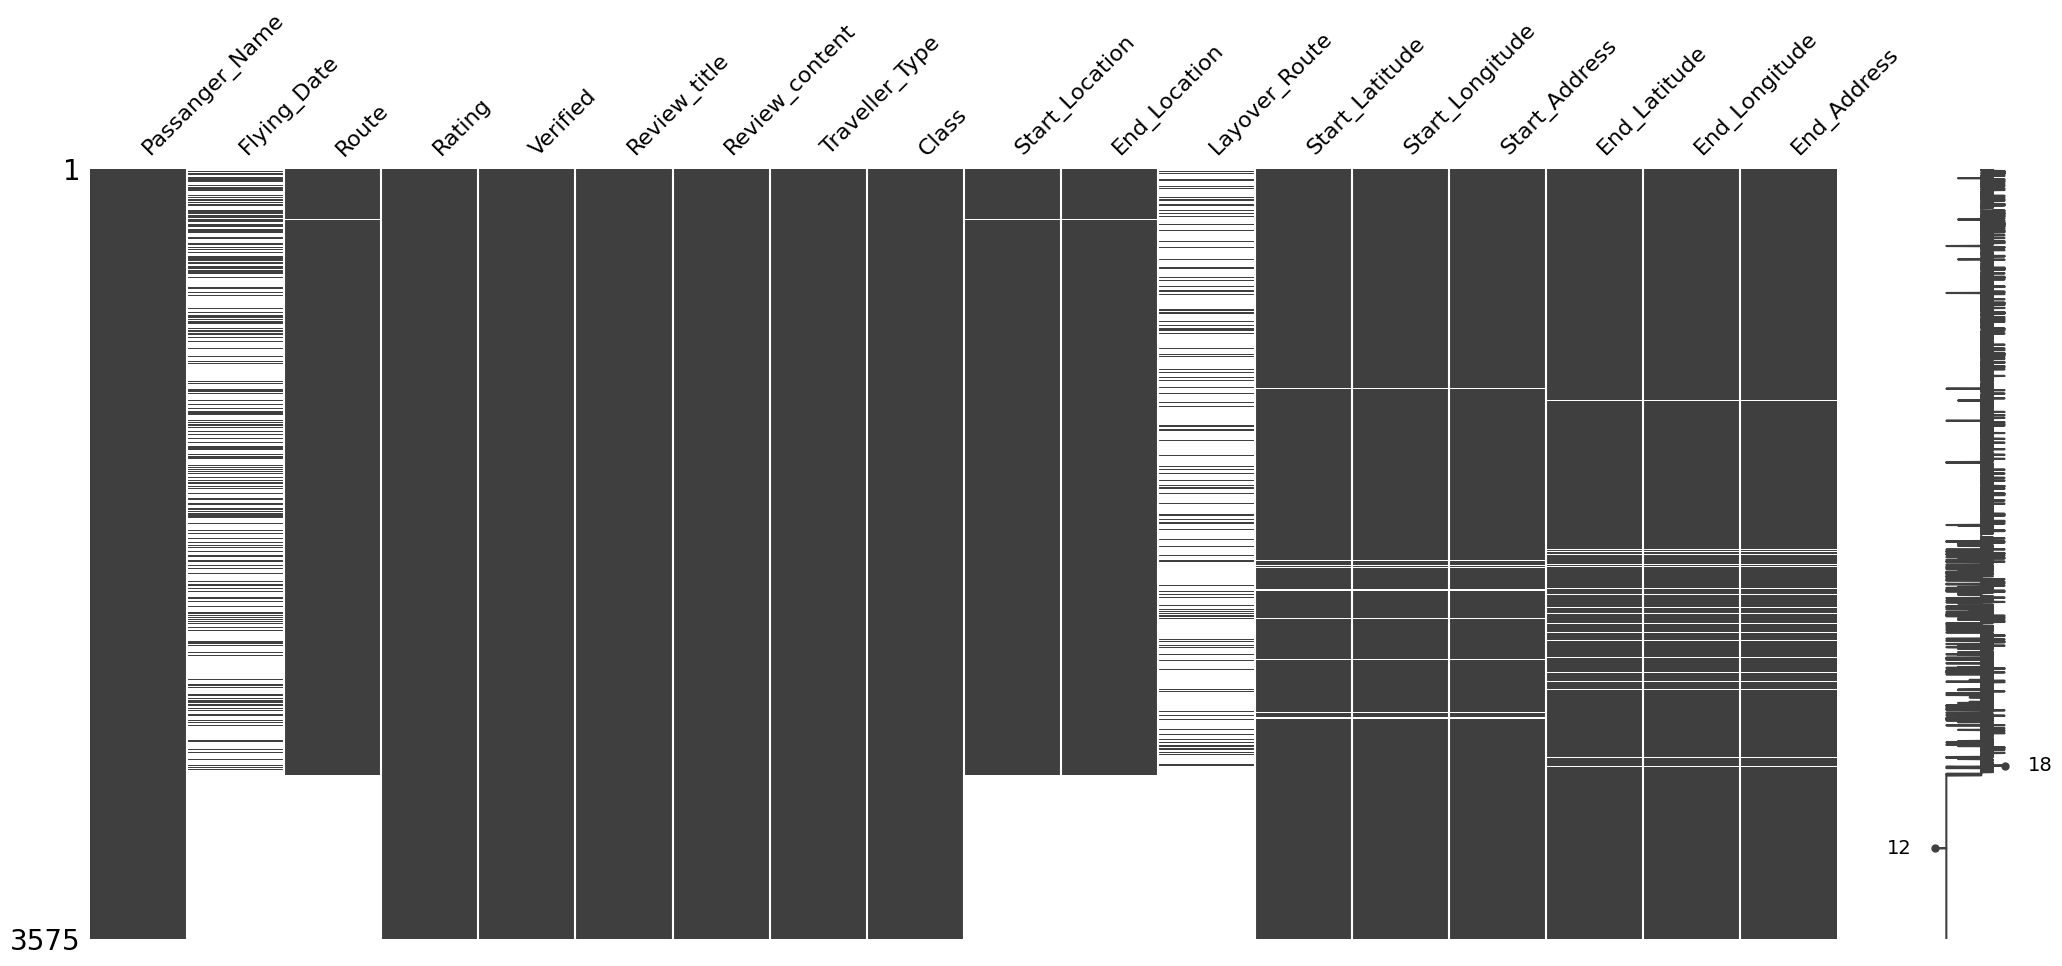

In [3]:
#2 calculating the fullness and plotting the asr
msno.matrix(asr)
# Calculate fullness percentage
fullness_percent = (asr.notnull().sum() / len(asr)) * 100

# Display as a Series or DataFrame for clarity
print(fullness_percent)

In [4]:
#3 Cleaning the data

initial_shape = asr.shape
asr.drop_duplicates(inplace=True)
final_shape = asr.shape

asr = asr.drop(columns=[
    'Start_Latitude', 'Start_Longitude', 'Start_Address',
    'End_Latitude', 'End_Longitude', 'End_Address',
    'Flying_Date', 'Layover_Route'
])
asr.dropna(subset=['Route', 'Passanger_Name'], inplace=True)

# Remove duplicate rows (if any)
asr.drop_duplicates(inplace=True)
# Reset index after dropping duplicates
asr.reset_index(drop=True, inplace=True)


Passanger_Name    100.0
Route             100.0
Rating            100.0
Verified          100.0
Review_title      100.0
Review_content    100.0
Traveller_Type    100.0
Class             100.0
Start_Location    100.0
End_Location      100.0
dtype: float64


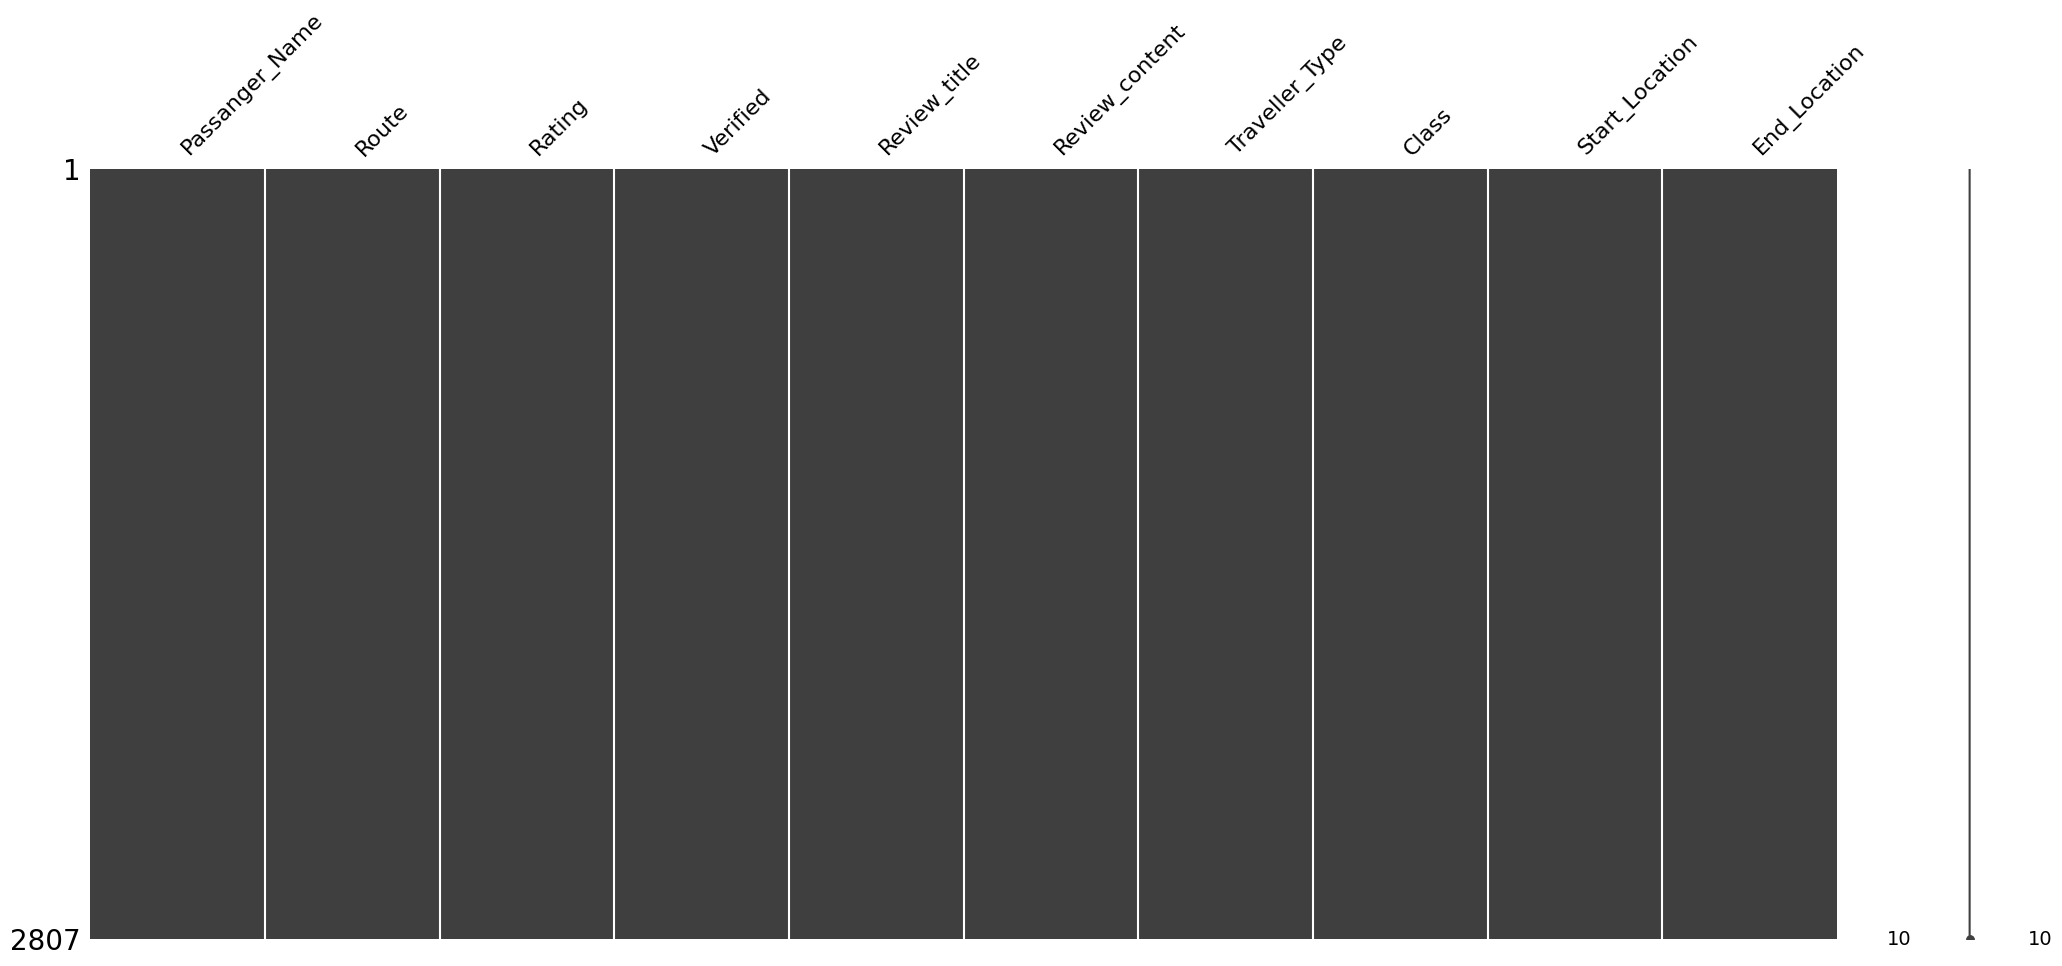

In [5]:
#4 recalculating the fullness 
msno.matrix(asr)
# Calculate fullness percentage
fullness_percent = (asr.notnull().sum() / len(asr)) * 100

# Display as a Series or DataFrame for clarity
print(fullness_percent)

**Customer_Comment.csv Cleaning**

In [6]:
#1 imprting the csv file cc
cc=pd.read_csv('/kaggle/input/airline-passangers-booking-data/Customer_comment.csv')
cc.info()
cc.describe()
cc.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                9424 non-null   int64 
 1   flight_number             9424 non-null   int64 
 2   origin_station_code       9424 non-null   object
 3   destination_station_code  9424 non-null   object
 4   scheduled_departure_date  9424 non-null   object
 5   arrival_delay_group       9424 non-null   object
 6   departure_delay_group     9424 non-null   object
 7   entity                    9424 non-null   object
 8   verbatim_text             9424 non-null   object
 9   seat_factor_band          9424 non-null   object
 10  ques_verbatim_text        9424 non-null   object
 11  loyalty_program_level     6920 non-null   object
 12  fleet_type_description    9424 non-null   object
 13  fleet_usage               9424 non-null   object
 14  response_group          

Unnamed: 0                     0
flight_number                  0
origin_station_code            0
destination_station_code       0
scheduled_departure_date       0
arrival_delay_group            0
departure_delay_group          0
entity                         0
verbatim_text                  0
seat_factor_band               0
ques_verbatim_text             0
loyalty_program_level       2504
fleet_type_description         0
fleet_usage                    0
response_group                 0
sentiments                     0
transformed_text            1019
dtype: int64

Unnamed: 0                  100.000000
flight_number               100.000000
origin_station_code         100.000000
destination_station_code    100.000000
scheduled_departure_date    100.000000
arrival_delay_group         100.000000
departure_delay_group       100.000000
entity                      100.000000
verbatim_text               100.000000
seat_factor_band            100.000000
ques_verbatim_text          100.000000
loyalty_program_level        73.429542
fleet_type_description      100.000000
fleet_usage                 100.000000
response_group              100.000000
sentiments                  100.000000
transformed_text             89.187182
dtype: float64


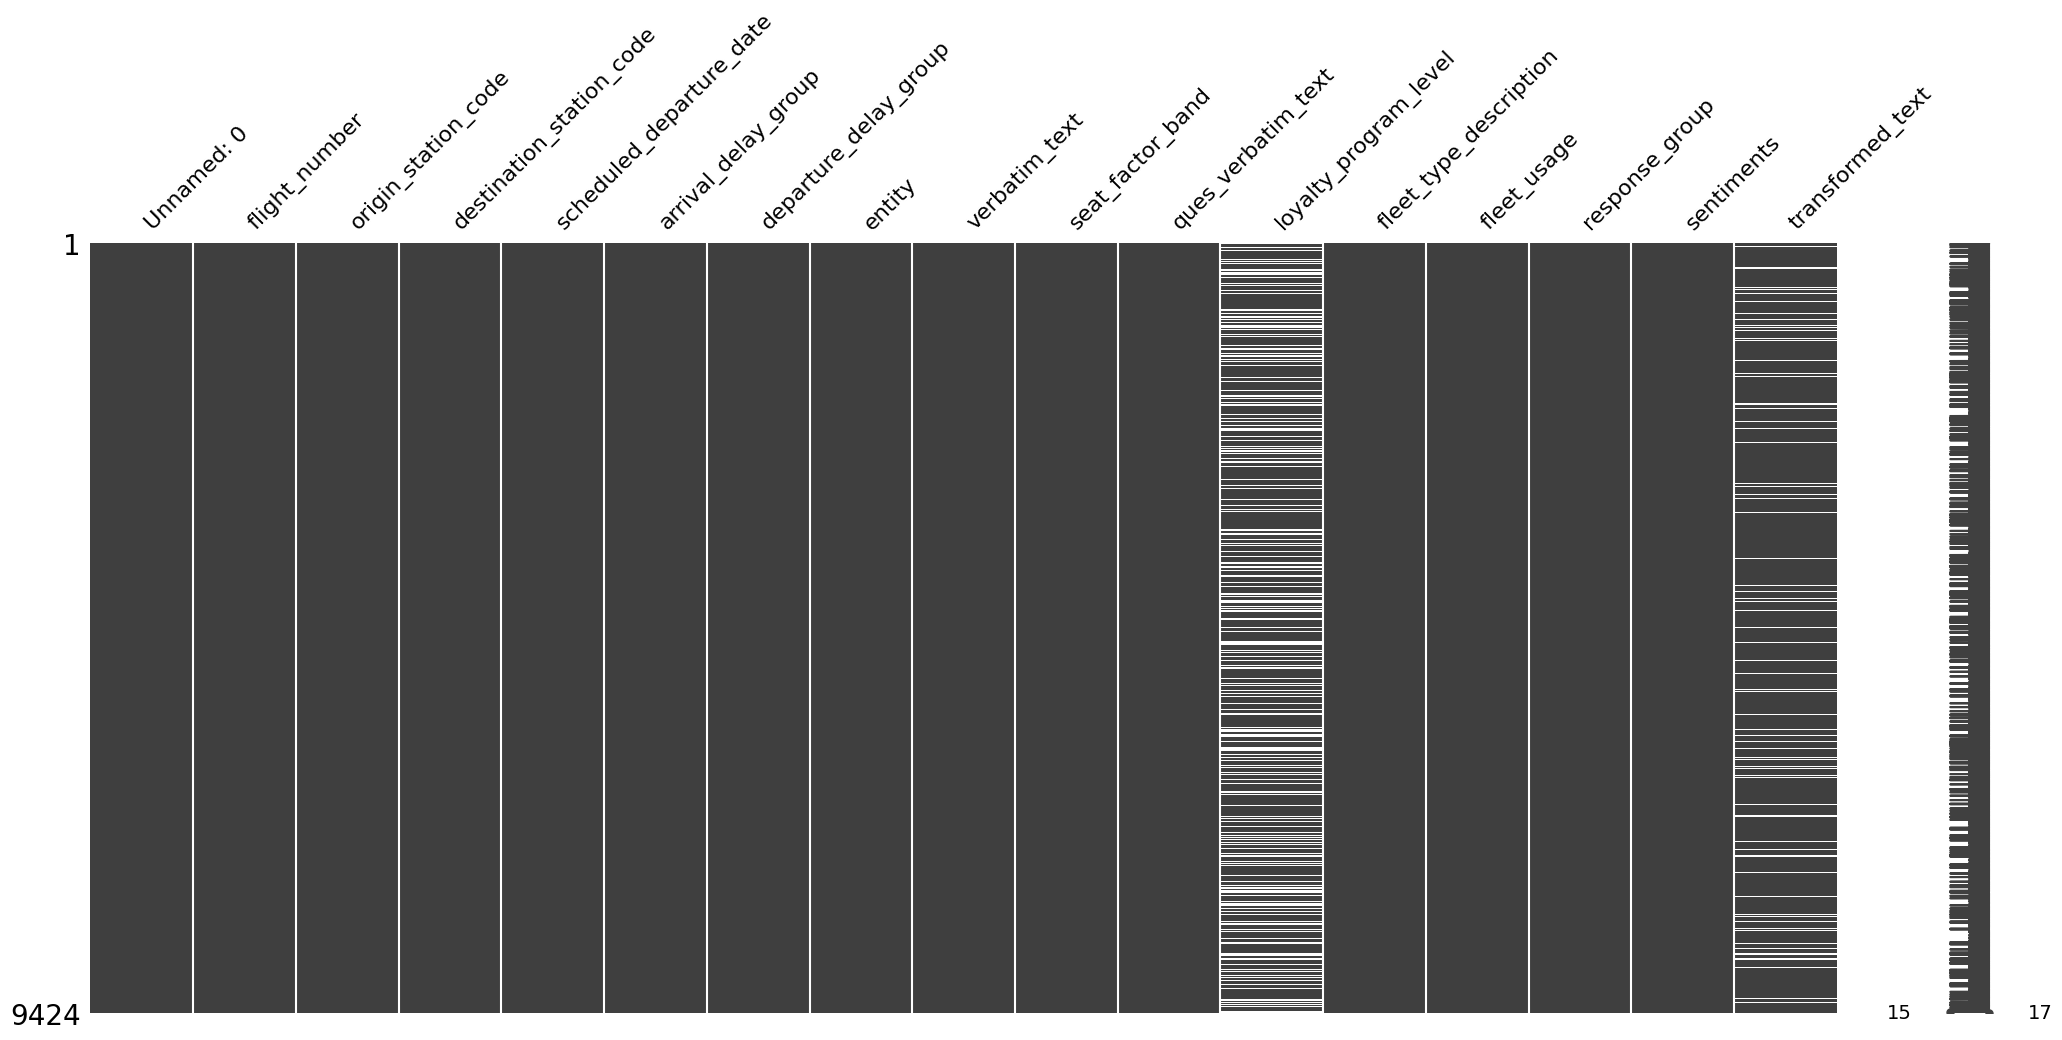

In [7]:
#2 calculating the fullness and plotting the cc
msno.matrix(cc)
# Calculate fullness percentage
fullness_percent = (cc.notnull().sum() / len(cc)) * 100

# Display as a Series or DataFrame for clarity
print(fullness_percent)

In [8]:
#3 Cleaning the data
#Drop redundant index column (export artifact)
if 'Unnamed: 0' in cc.columns:
    cc.drop(columns=['Unnamed: 0'], inplace=True)

#Handle missing values in categorical column 'loyalty_program_level'
mode_value = cc['loyalty_program_level'].mode()[0]
cc['loyalty_program_level'] = cc['loyalty_program_level'].fillna(mode_value)

#Clean 'transformed_text' column
placeholders = ['none', 'na', 'n/a', 'nan', ' ', '']
cc['transformed_text'] = cc['transformed_text'].replace(placeholders, np.nan)
cc['transformed_text'] = cc['transformed_text'].fillna(cc['verbatim_text'])

#Strip leading/trailing whitespace from text-based columns
text_columns = ['verbatim_text', 'ques_verbatim_text', 'transformed_text']
for col in text_columns:
    cc[col] = cc[col].astype(str).str.strip()

# Remove duplicate rows (if any)
cc.drop_duplicates(inplace=True)

# Reset index after dropping duplicates
cc.reset_index(drop=True, inplace=True)


flight_number               100.0
origin_station_code         100.0
destination_station_code    100.0
scheduled_departure_date    100.0
arrival_delay_group         100.0
departure_delay_group       100.0
entity                      100.0
verbatim_text               100.0
seat_factor_band            100.0
ques_verbatim_text          100.0
loyalty_program_level       100.0
fleet_type_description      100.0
fleet_usage                 100.0
response_group              100.0
sentiments                  100.0
transformed_text            100.0
dtype: float64


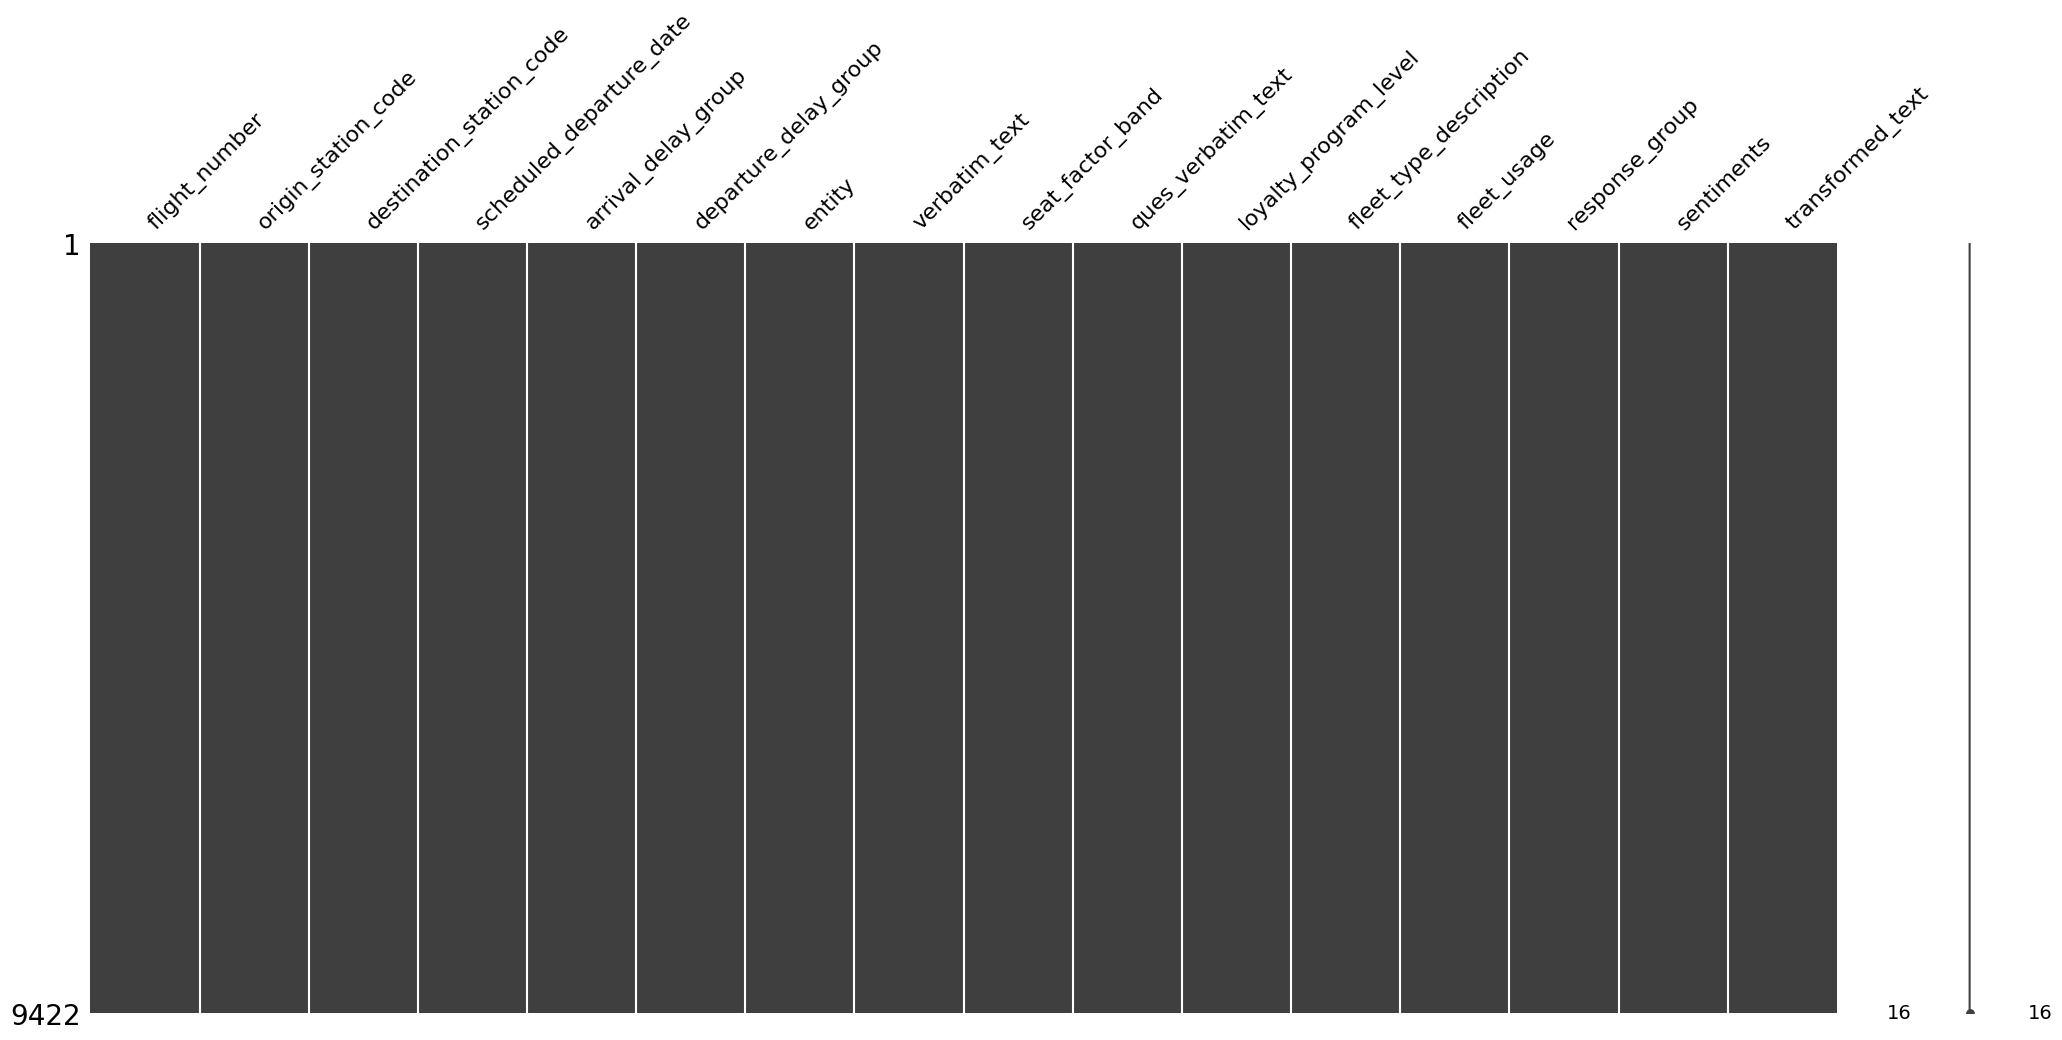

In [9]:
#4 recalculating the fullness and plotting the cc
msno.matrix(cc)
# Calculate fullness percentage
fullness_percent = (cc.notnull().sum() / len(cc)) * 100

# Display as a Series or DataFrame for clarity
print(fullness_percent)

**Passanger_booking.scv Cleaning**

In [10]:
#1 imprting the csv file pbd
pbd=pd.read_csv('/kaggle/input/airline-passangers-booking-data/Passanger_booking_data.csv')
pbd.info()
pbd.describe()
pbd.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50002 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50002 non-null  int64  
 1   sales_channel          50002 non-null  object 
 2   trip_type              50002 non-null  object 
 3   purchase_lead          50002 non-null  int64  
 4   length_of_stay         50002 non-null  int64  
 5   flight_hour            50002 non-null  int64  
 6   flight_day             50002 non-null  object 
 7   route                  50002 non-null  object 
 8   booking_origin         50002 non-null  object 
 9   wants_extra_baggage    50002 non-null  int64  
 10  wants_preferred_seat   50002 non-null  int64  
 11  wants_in_flight_meals  50002 non-null  int64  
 12  flight_duration        50002 non-null  float64
 13  booking_complete       50002 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

num_passengers           100.0
sales_channel            100.0
trip_type                100.0
purchase_lead            100.0
length_of_stay           100.0
flight_hour              100.0
flight_day               100.0
route                    100.0
booking_origin           100.0
wants_extra_baggage      100.0
wants_preferred_seat     100.0
wants_in_flight_meals    100.0
flight_duration          100.0
booking_complete         100.0
dtype: float64


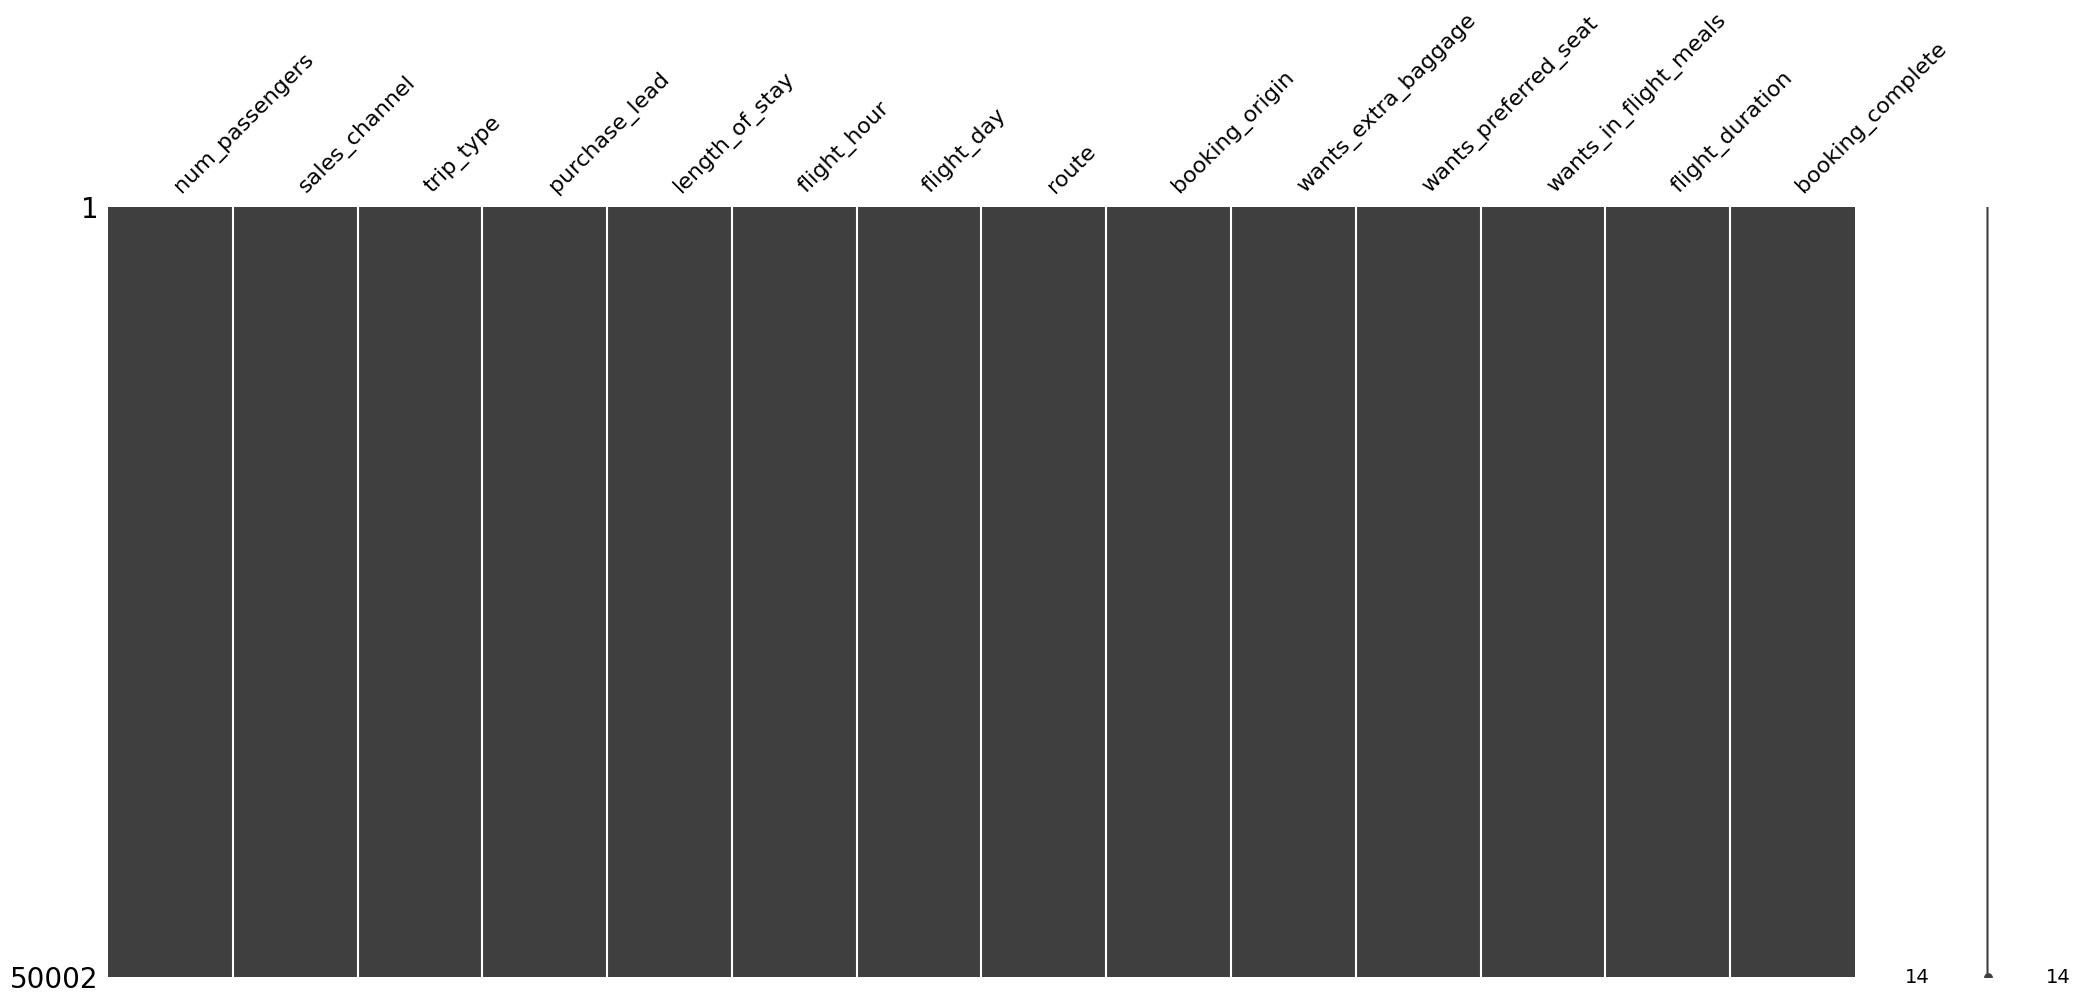

In [11]:
#2 calculating the fullness and plotting the pbd
msno.matrix(pbd)
# Calculate fullness percentage
fullness_percent = (pbd.notnull().sum() / len(pbd)) * 100

# Display as a Series or DataFrame for clarity
print(fullness_percent)

In [12]:
#3 Cleaning the data
# Remove duplicate rows (if any)
pbd.drop_duplicates(inplace=True)
# Reset index after dropping duplicates
pbd.reset_index(drop=True, inplace=True)





num_passengers           100.0
sales_channel            100.0
trip_type                100.0
purchase_lead            100.0
length_of_stay           100.0
flight_hour              100.0
flight_day               100.0
route                    100.0
booking_origin           100.0
wants_extra_baggage      100.0
wants_preferred_seat     100.0
wants_in_flight_meals    100.0
flight_duration          100.0
booking_complete         100.0
dtype: float64


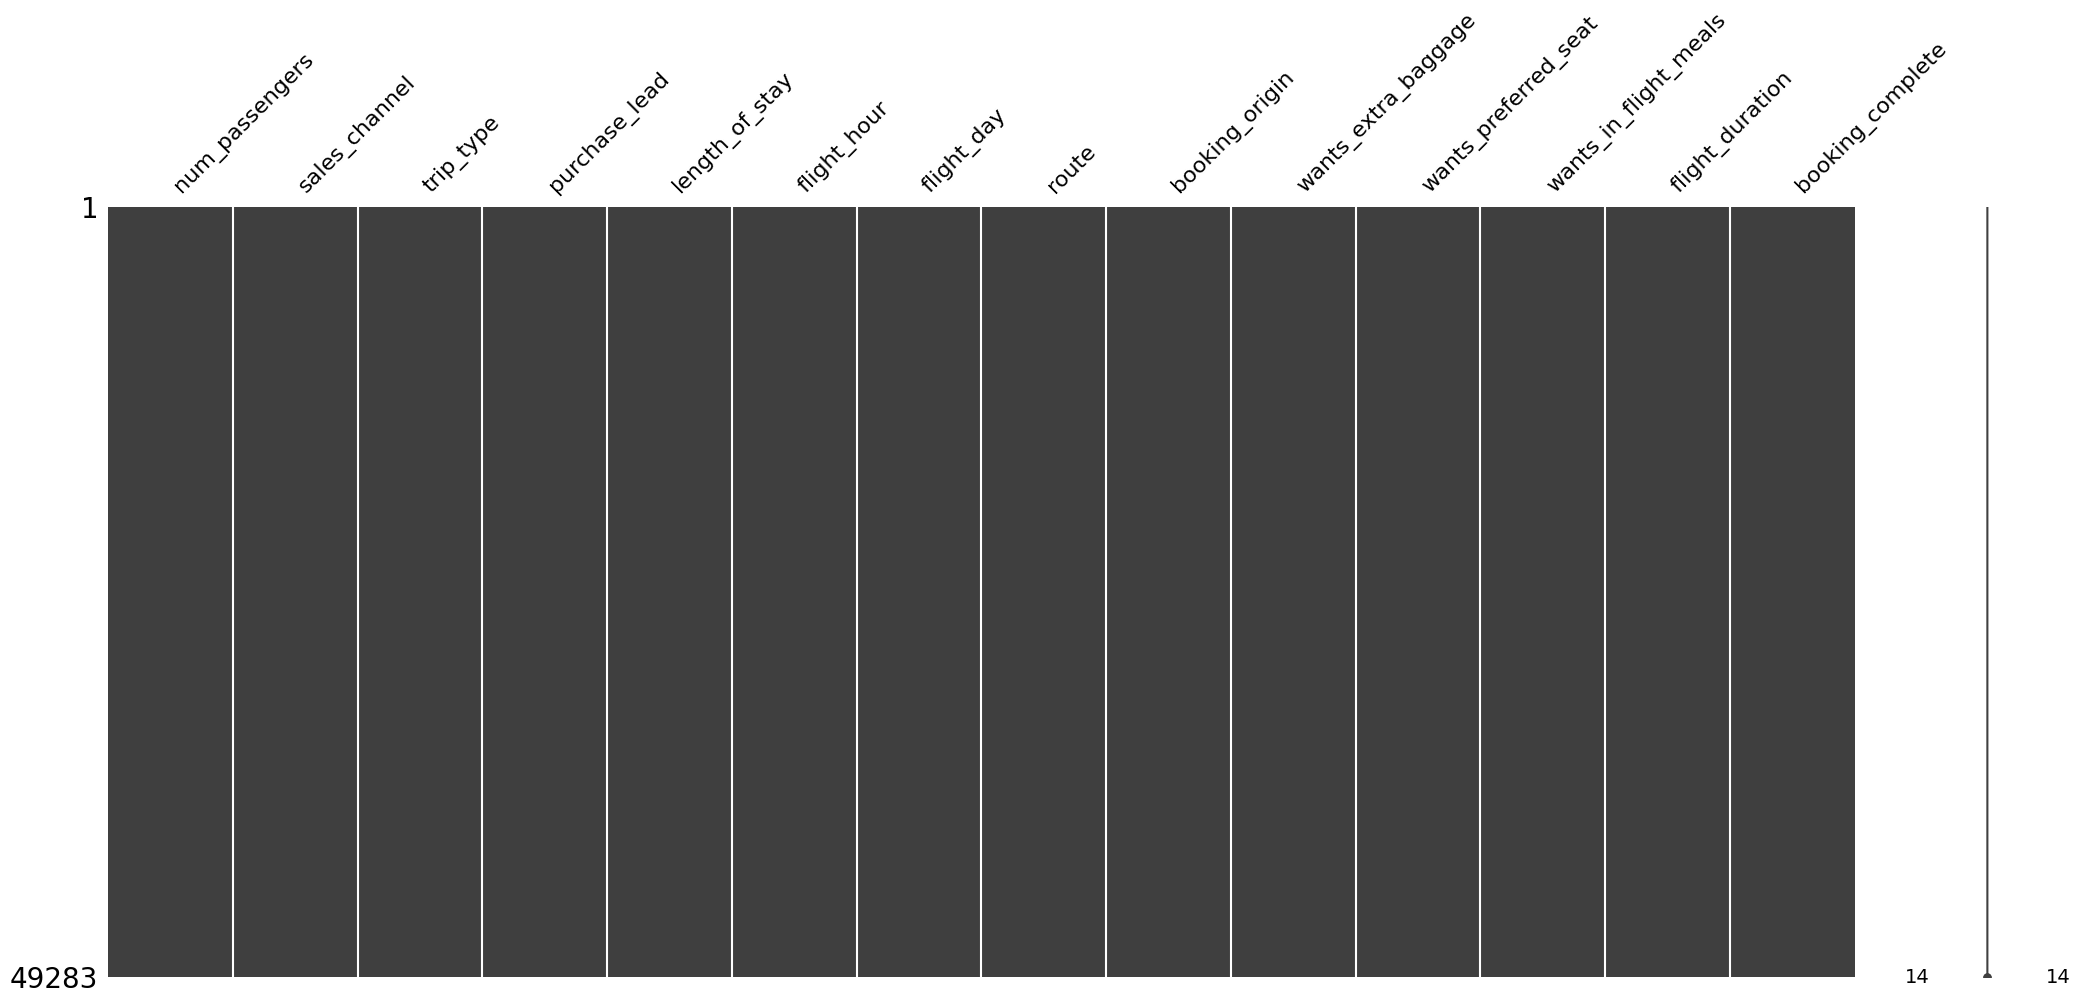

In [13]:
#4 recalculating the fullness and plotting the pbd
msno.matrix(pbd)
# Calculate fullness percentage
fullness_percent = (pbd.notnull().sum() / len(pbd)) * 100

# Display as a Series or DataFrame for clarity
print(fullness_percent)

**Survey data_Inflight Satisfaction Score.csv cleaning**

In [14]:
#1 importing the csv file
sd=pd.read_csv('/kaggle/input/airline-passangers-booking-data/Survey data_Inflight Satisfaction Score.csv')
sd.info()
sd.describe()
sd.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47074 entries, 0 to 47073
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   flight_number                     47074 non-null  int64 
 1   origin_station_code               47074 non-null  object
 2   destination_station_code          47074 non-null  object
 3   record_locator                    47074 non-null  object
 4   scheduled_departure_date          47074 non-null  object
 5   question_text                     47074 non-null  object
 6   score                             47074 non-null  object
 7   satisfaction_type                 34963 non-null  object
 8   driver_sub_group1                 47074 non-null  object
 9   driver_sub_group2                 47074 non-null  object
 10  arrival_delay_minutes             47074 non-null  int64 
 11  arrival_delay_group               47074 non-null  object
 12  cabin_code_desc   

flight_number                           0
origin_station_code                     0
destination_station_code                0
record_locator                          0
scheduled_departure_date                0
question_text                           0
score                                   0
satisfaction_type                   12111
driver_sub_group1                       0
driver_sub_group2                       0
arrival_delay_minutes                   0
arrival_delay_group                     0
cabin_code_desc                         0
cabin_name                          19980
entity                                  3
number_of_legs                          0
seat_factor_band                        0
loyalty_program_level               11616
generation                              0
fleet_type_description                  0
fleet_usage                             0
equipment_type_code                     0
ua_uax                                  0
actual_flown_miles                

flight_number                       100.000000
origin_station_code                 100.000000
destination_station_code            100.000000
record_locator                      100.000000
scheduled_departure_date            100.000000
question_text                       100.000000
score                               100.000000
satisfaction_type                    74.272422
driver_sub_group1                   100.000000
driver_sub_group2                   100.000000
arrival_delay_minutes               100.000000
arrival_delay_group                 100.000000
cabin_code_desc                     100.000000
cabin_name                           57.556188
entity                               99.993627
number_of_legs                      100.000000
seat_factor_band                    100.000000
loyalty_program_level                75.323958
generation                          100.000000
fleet_type_description              100.000000
fleet_usage                         100.000000
equipment_typ

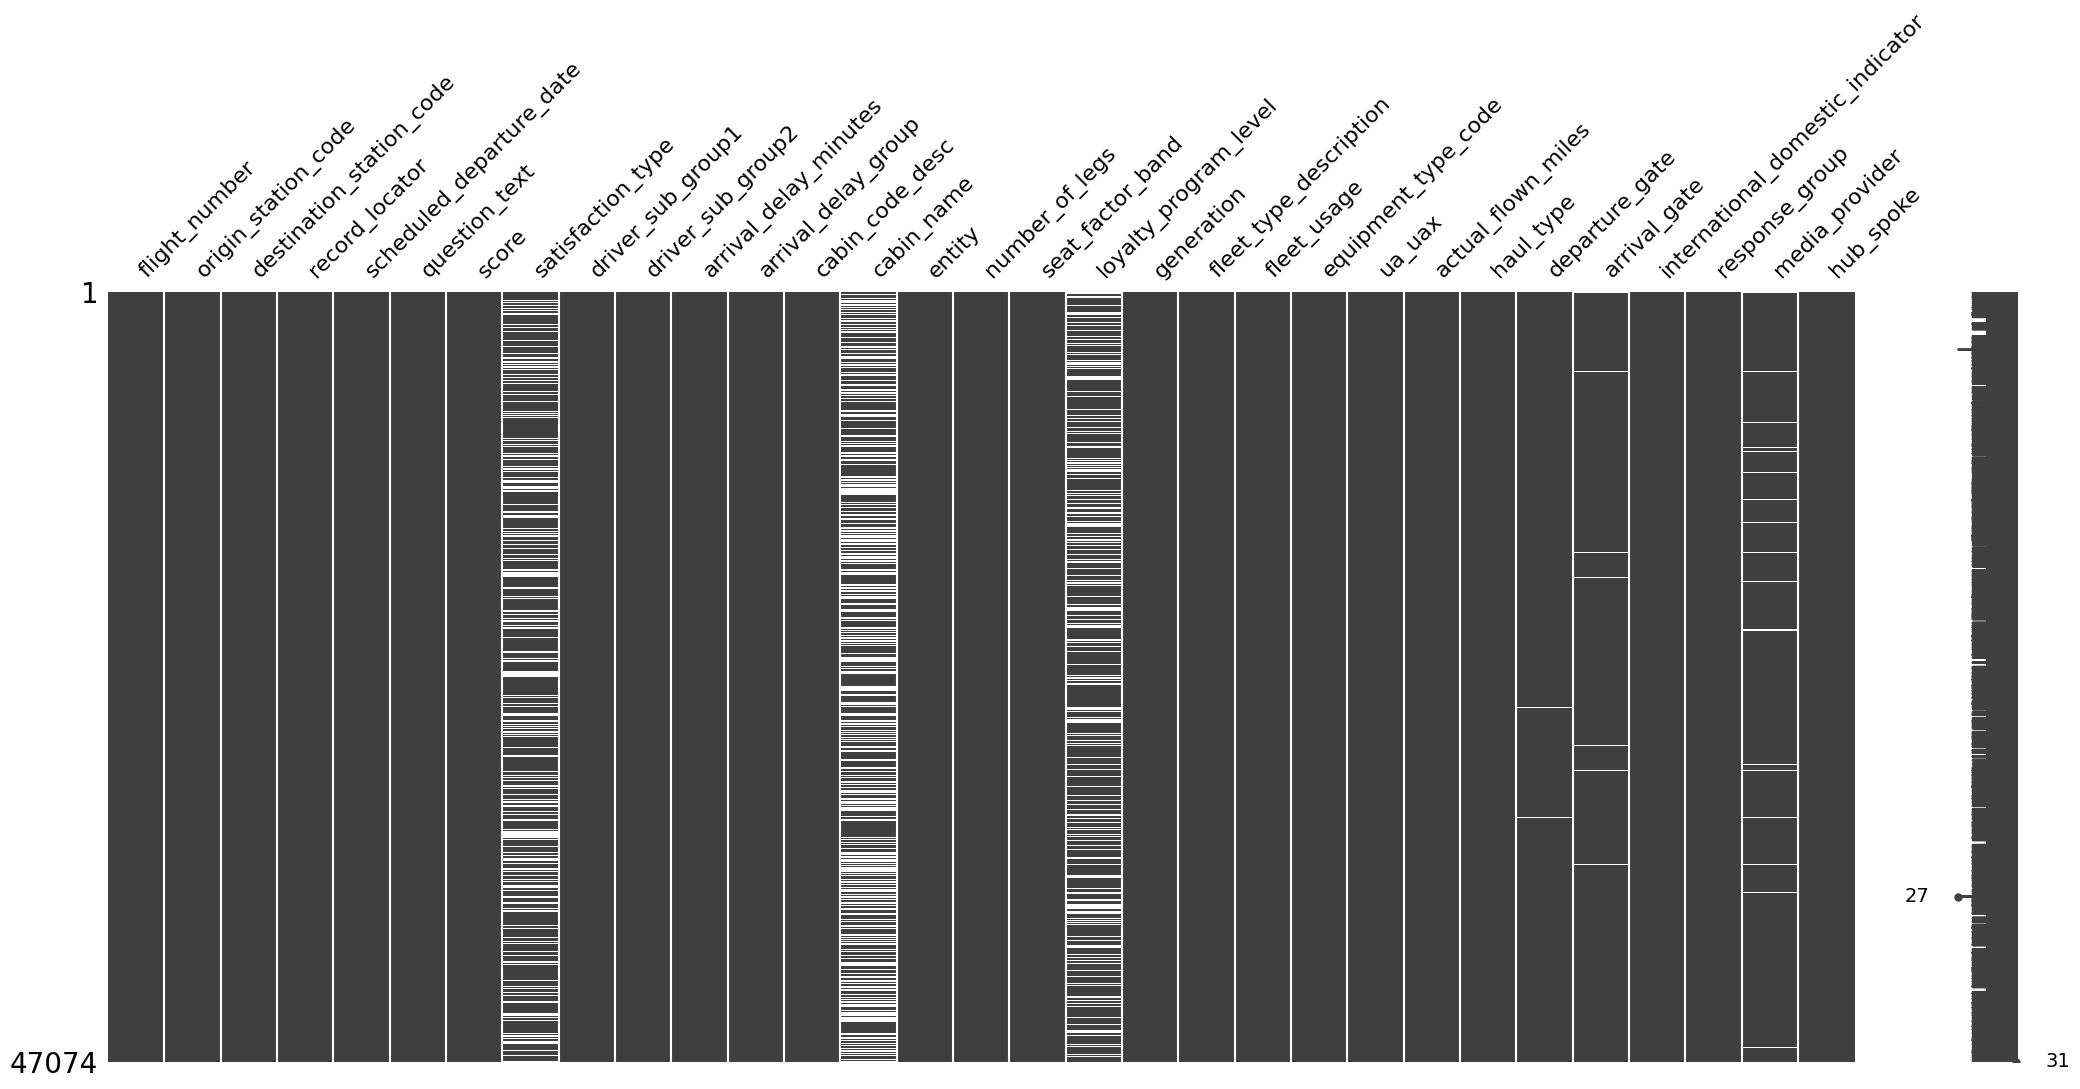

In [15]:
#2 calculating the fullness and plotting the sd
msno.matrix(sd)
# Calculate fullness percentage
fullness_percent = (sd.notnull().sum() / len(sd)) * 100

# Display as a Series or DataFrame for clarity
print(fullness_percent)

In [16]:
#3 Cleaning the data
#Handle missing values in categorical column 'loyalty_program_level'
#sd['loyalty_program_level'] = sd['loyalty_program_level'].fillna('None')
#sd['media_provider'] = sd['media_provider'].fillna('None')
sd.dropna(subset=[ 'satisfaction_type','satisfaction_type','loyalty_program_level'], inplace=True)
sd = sd.drop(columns=['departure_gate','arrival_gate'])
sd['cabin_name'] = sd['cabin_name'].fillna(sd['cabin_name'].mode()[0])
sd['media_provider'] = sd['media_provider'].fillna(sd['media_provider'].mode()[0])
sd['entity'] = sd['entity'].fillna(sd['entity'].mode()[0])
# Remove duplicate rows (if any)
sd.drop_duplicates(inplace=True)

# Reset index after dropping duplicates
sd.reset_index(drop=True, inplace=True)


flight_number                       100.0
origin_station_code                 100.0
destination_station_code            100.0
record_locator                      100.0
scheduled_departure_date            100.0
question_text                       100.0
score                               100.0
satisfaction_type                   100.0
driver_sub_group1                   100.0
driver_sub_group2                   100.0
arrival_delay_minutes               100.0
arrival_delay_group                 100.0
cabin_code_desc                     100.0
cabin_name                          100.0
entity                              100.0
number_of_legs                      100.0
seat_factor_band                    100.0
loyalty_program_level               100.0
generation                          100.0
fleet_type_description              100.0
fleet_usage                         100.0
equipment_type_code                 100.0
ua_uax                              100.0
actual_flown_miles                

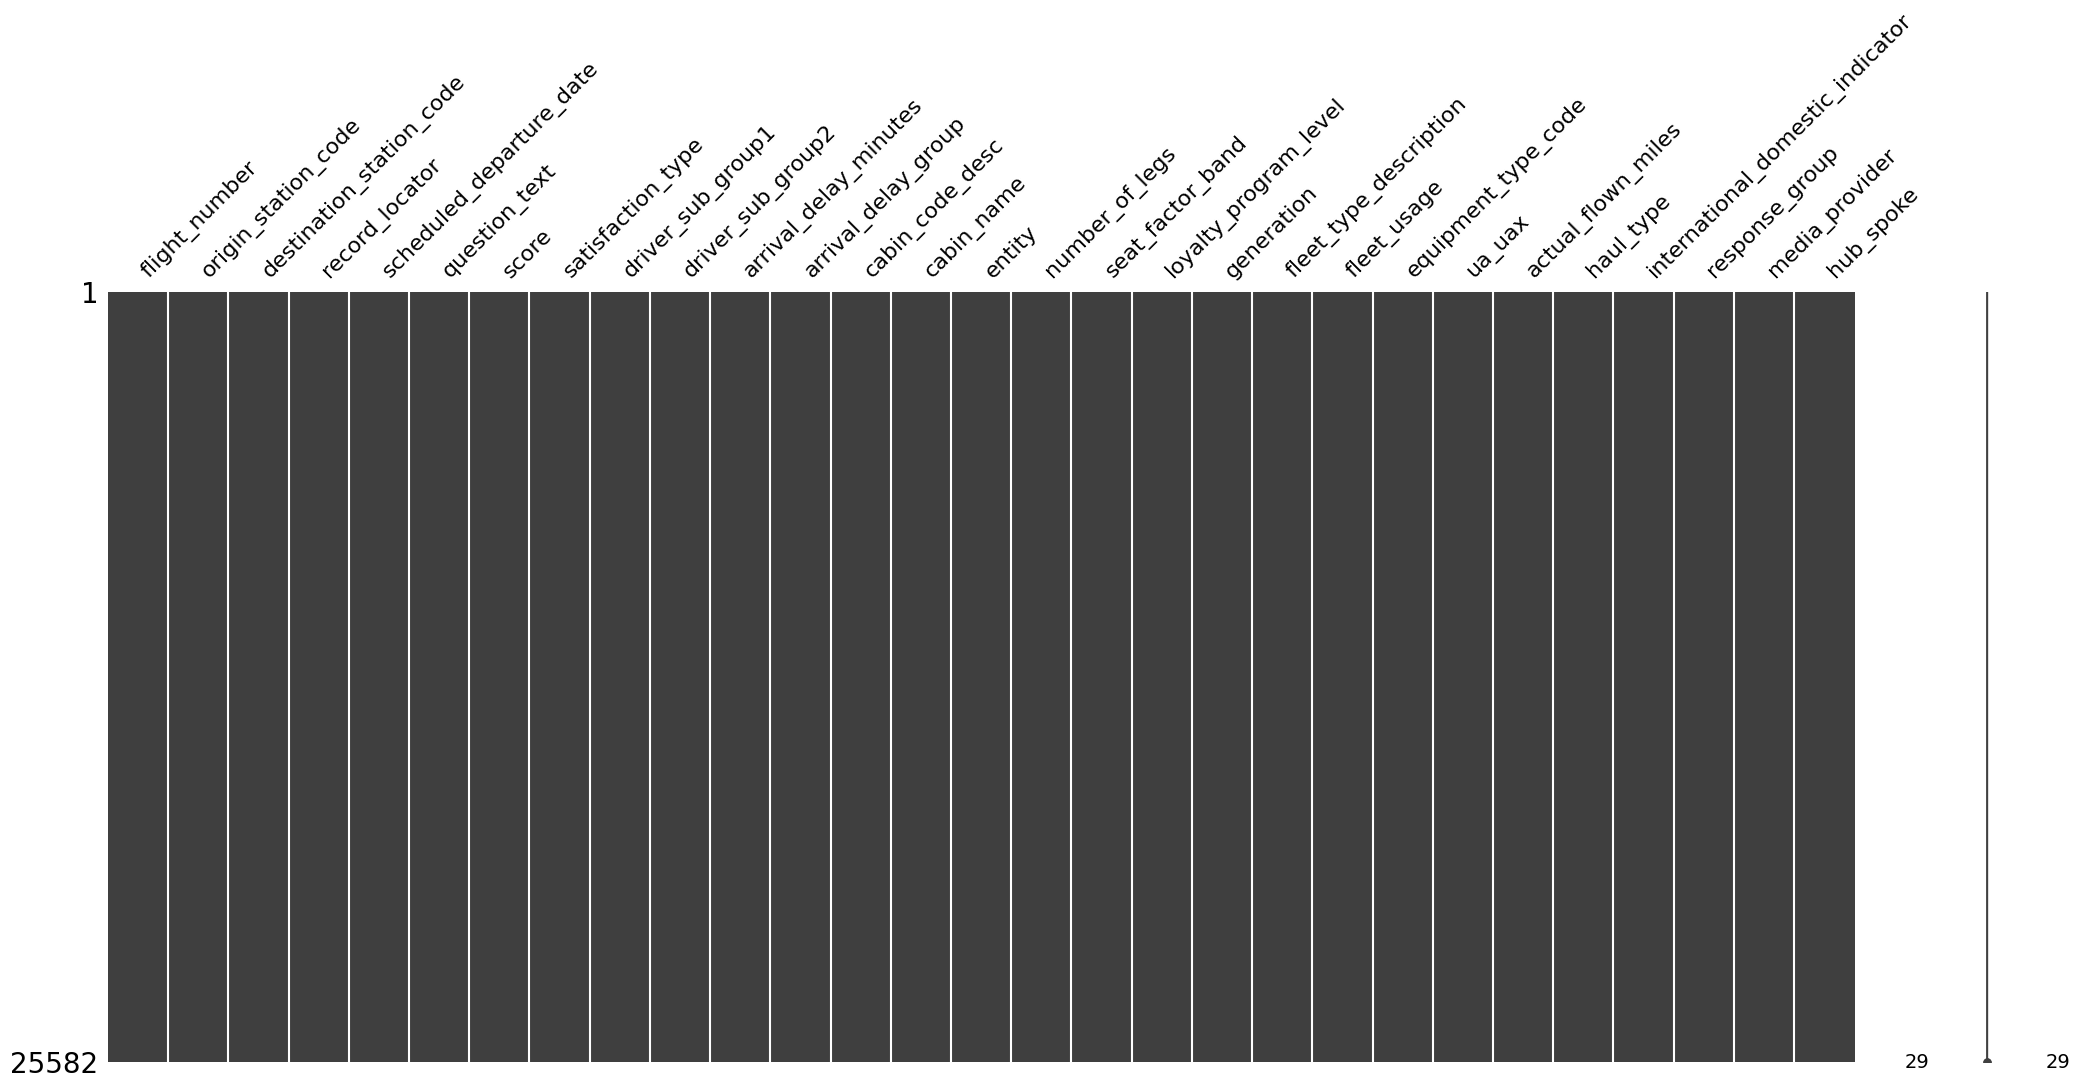

In [17]:
#4 recalculating the fullness and plotting the sd
msno.matrix(sd)
# Calculate fullness percentage
fullness_percent = (sd.notnull().sum() / len(sd)) * 100

# Display as a Series or DataFrame for clarity
print(fullness_percent)

# Data-Engineering Questions

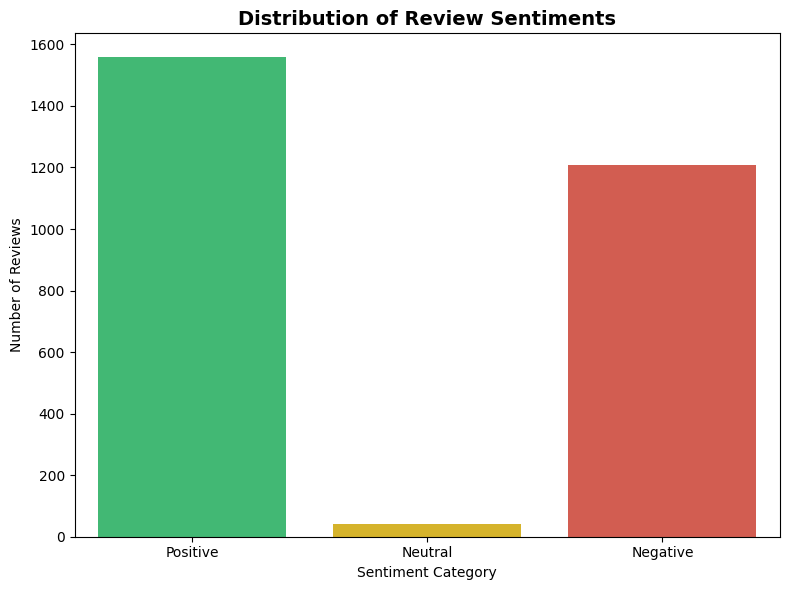

In [18]:

# Initialize analyzer
sia = SentimentIntensityAnalyzer()

# Create sentiment score column using Review_content
asr['sentiment_score'] = asr['Review_content'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# Optional: label sentiment for clarity
asr['sentiment_label'] = asr['sentiment_score'].apply(
    lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral')
)

# Quick check
asr[['Review_content', 'sentiment_score', 'sentiment_label']].head()

# ============================================================
# ✈️ Sentiment Distribution Visualization
# ============================================================

plt.figure(figsize=(8,6))
sns.countplot(
    data=asr,
    x='sentiment_label',
    palette={'Positive':'#2ecc71', 'Neutral':'#f1c40f', 'Negative':'#e74c3c'},
    order=['Positive', 'Neutral', 'Negative']
)
plt.title("Distribution of Review Sentiments", fontsize=14, weight='bold')
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()



**What are the top 10 most popular flight routes?**

Top 10 Most Popular Flight Routes:
route
AKLKUL    2620
PENTPE     912
MELSGN     833
ICNSIN     793
DMKKIX     729
ICNSYD     683
DMKPER     677
DPSICN     658
DMKOOL     652
MELTPE     637
Name: count, dtype: int64


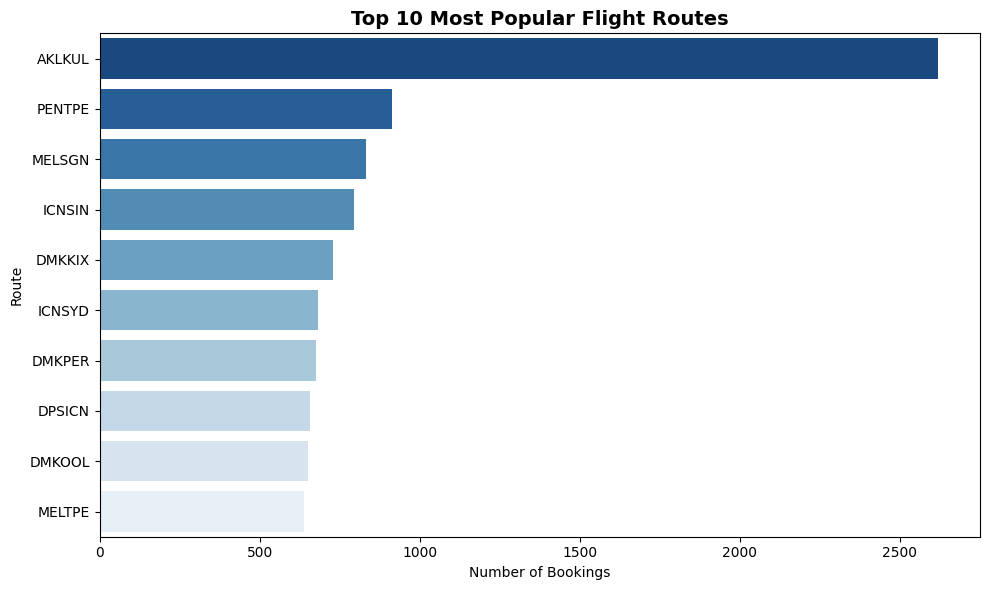

In [19]:
# Count how many times each route appears
top_routes = pbd['route'].value_counts().head(10)

# Display top 10 routes in the console
print("Top 10 Most Popular Flight Routes:")
print(top_routes)

# --- Visualization ---
plt.figure(figsize=(10,6))
sns.barplot(x=top_routes.values, y=top_routes.index, palette="Blues_r")
plt.title("Top 10 Most Popular Flight Routes", fontsize=14, weight='bold')
plt.xlabel("Number of Bookings")
plt.ylabel("Route")
plt.tight_layout()
plt.show()

**What is the distribution of bookings across flight hours?**

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


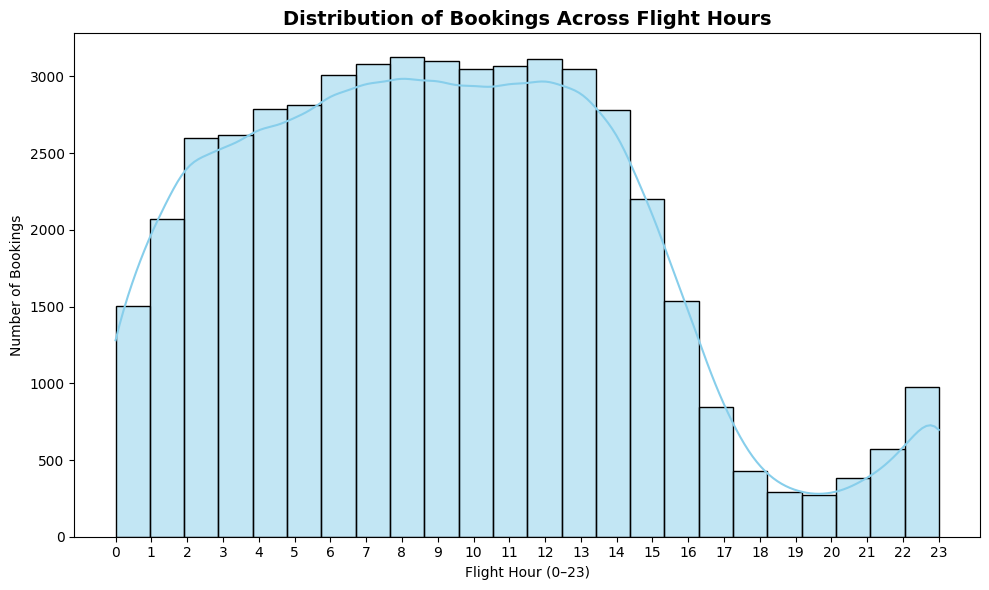

In [20]:
plt.figure(figsize=(10,6))
sns.histplot(data=pbd, x='flight_hour', bins=24, kde=True, color='skyblue')
plt.title("Distribution of Bookings Across Flight Hours", fontsize=14, weight='bold')
plt.xlabel("Flight Hour (0–23)")
plt.ylabel("Number of Bookings")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

**By analyzing review patterns, which traveler type and class combination yields the highest and lowest ratings?**

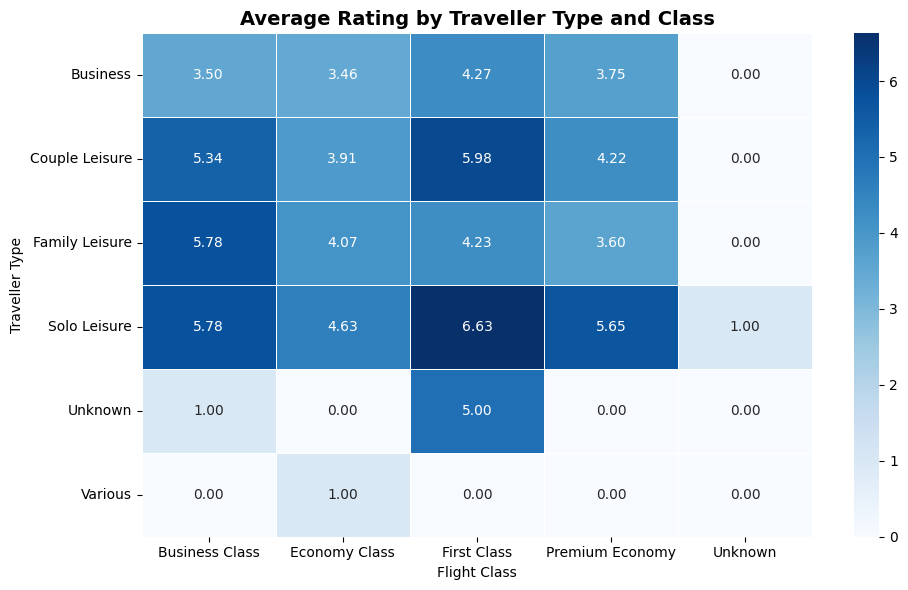

✅ Highest Average Rating:
Traveller Type: Solo Leisure, Class: First Class, Rating: 6.63

❌ Lowest Average Rating:
Traveller Type: Solo Leisure, Class: Unknown, Rating: 1.00


In [21]:
# ============================================================
# ✈️ Data Engineering Question:
# By analyzing review patterns, which traveler type and class 
# combination yields the highest and lowest ratings?
# ============================================================

# --- 1️⃣ Data Preparation ---

# Ensure Rating column is numeric and handle missing values
asr['Rating'] = pd.to_numeric(asr['Rating'], errors='coerce')

# Drop rows missing any of the key columns
asr = asr.dropna(subset=['Rating', 'Traveller_Type', 'Class'])

# --- 2️⃣ Group data and calculate average ratings ---
rating_summary = (
    asr.groupby(['Traveller_Type', 'Class'])['Rating']
    .mean()
    .reset_index()
)

# --- 3️⃣ Create a pivot table for the heatmap ---
rating_pivot = rating_summary.pivot(
    index='Traveller_Type',
    columns='Class',
    values='Rating'
)

# Fill missing cells with 0 (or you can use np.nan if you prefer blank)
rating_pivot = rating_pivot.fillna(0)

# --- 4️⃣ Plot the Heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(
    rating_pivot, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    linewidths=0.5
)
plt.title("Average Rating by Traveller Type and Class", fontsize=14, weight='bold')
plt.xlabel("Flight Class")
plt.ylabel("Traveller Type")
plt.tight_layout()
plt.show()

# --- 5️⃣ Identify highest and lowest rated combinations ---
best_combo = rating_summary.loc[rating_summary['Rating'].idxmax()]
worst_combo = rating_summary.loc[rating_summary['Rating'].idxmin()]

print("✅ Highest Average Rating:")
print(f"Traveller Type: {best_combo['Traveller_Type']}, Class: {best_combo['Class']}, Rating: {best_combo['Rating']:.2f}\n")

print("❌ Lowest Average Rating:")
print(f"Traveller Type: {worst_combo['Traveller_Type']}, Class: {worst_combo['Class']}, Rating: {worst_combo['Rating']:.2f}")


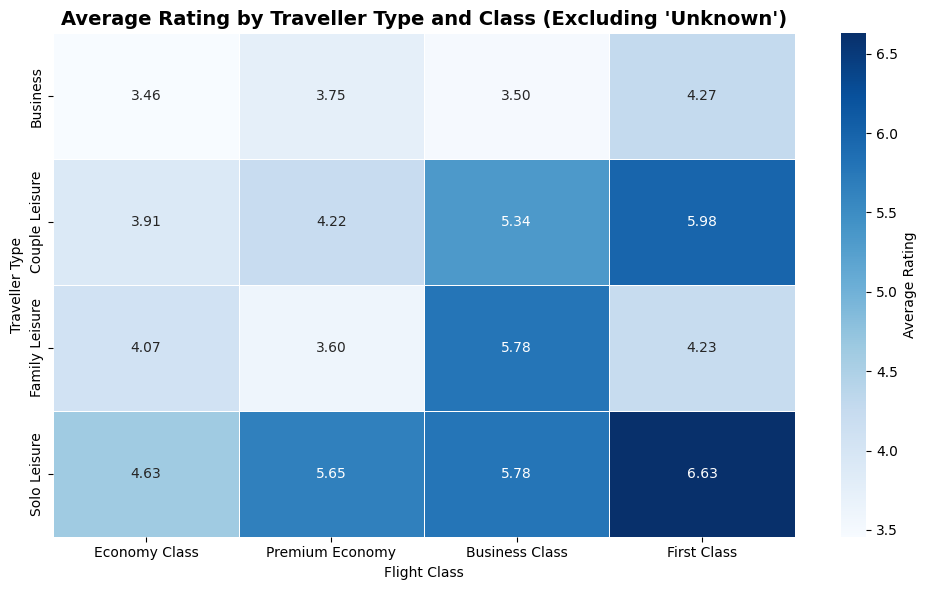

✅ Highest Average Rating:
Traveller Type: Solo Leisure, Class: First Class, Rating: 6.63

❌ Lowest Average Rating:
Traveller Type: Business, Class: Economy Class, Rating: 3.46


In [22]:
# ============================================================
# ✈️ Data Engineering Question:
# Which traveler type and class combination yields 
# the highest and lowest ratings? (Cleaned + Ordered)
# ============================================================

# --- 1️⃣ Ensure Rating column is numeric
asr['Rating'] = pd.to_numeric(asr['Rating'], errors='coerce')

# --- 2️⃣ Drop rows missing key fields
asr = asr.dropna(subset=['Rating', 'Traveller_Type', 'Class'])

# --- 3️⃣ Remove 'Unknown' categories
asr = asr[
    (asr['Traveller_Type'].str.lower() != 'unknown') &
    (asr['Class'].str.lower() != 'unknown')
]

# --- 4️⃣ Define a logical order for traveler types and flight classes ---
traveller_order = ['Business', 'Couple Leisure', 'Family Leisure', 'Solo Leisure']
class_order = ['Economy Class', 'Premium Economy', 'Business Class', 'First Class']

# --- 5️⃣ Apply ordering to ensure a neat heatmap layout ---
asr['Traveller_Type'] = pd.Categorical(asr['Traveller_Type'], categories=traveller_order, ordered=True)
asr['Class'] = pd.Categorical(asr['Class'], categories=class_order, ordered=True)

# --- 6️⃣ Group and calculate average ratings (silence future warning) ---
rating_summary = (
    asr.groupby(['Traveller_Type', 'Class'], observed=False)['Rating']
    .mean()
    .reset_index()
)

# --- 7️⃣ Create a pivot table for the heatmap ---
rating_pivot = rating_summary.pivot(
    index='Traveller_Type',
    columns='Class',
    values='Rating'
).fillna(0)

# --- 8️⃣ Plot heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(
    rating_pivot, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    linewidths=0.5,
    cbar_kws={'label': 'Average Rating'}
)
plt.title("Average Rating by Traveller Type and Class (Excluding 'Unknown')", fontsize=14, weight='bold')
plt.xlabel("Flight Class")
plt.ylabel("Traveller Type")
plt.tight_layout()
plt.show()

# --- 9️⃣ Identify highest and lowest rated combinations ---
best_combo = rating_summary.loc[rating_summary['Rating'].idxmax()]
worst_combo = rating_summary.loc[rating_summary['Rating'].idxmin()]

print("✅ Highest Average Rating:")
print(f"Traveller Type: {best_combo['Traveller_Type']}, Class: {best_combo['Class']}, Rating: {best_combo['Rating']:.2f}\n")

print("❌ Lowest Average Rating:")
print(f"Traveller Type: {worst_combo['Traveller_Type']}, Class: {worst_combo['Class']}, Rating: {worst_combo['Rating']:.2f}")


# Predictive Modeling Task

**○ Satisfied if Rating >= 5 ○ Dissatisfied if Rating < 5**

<Axes: >

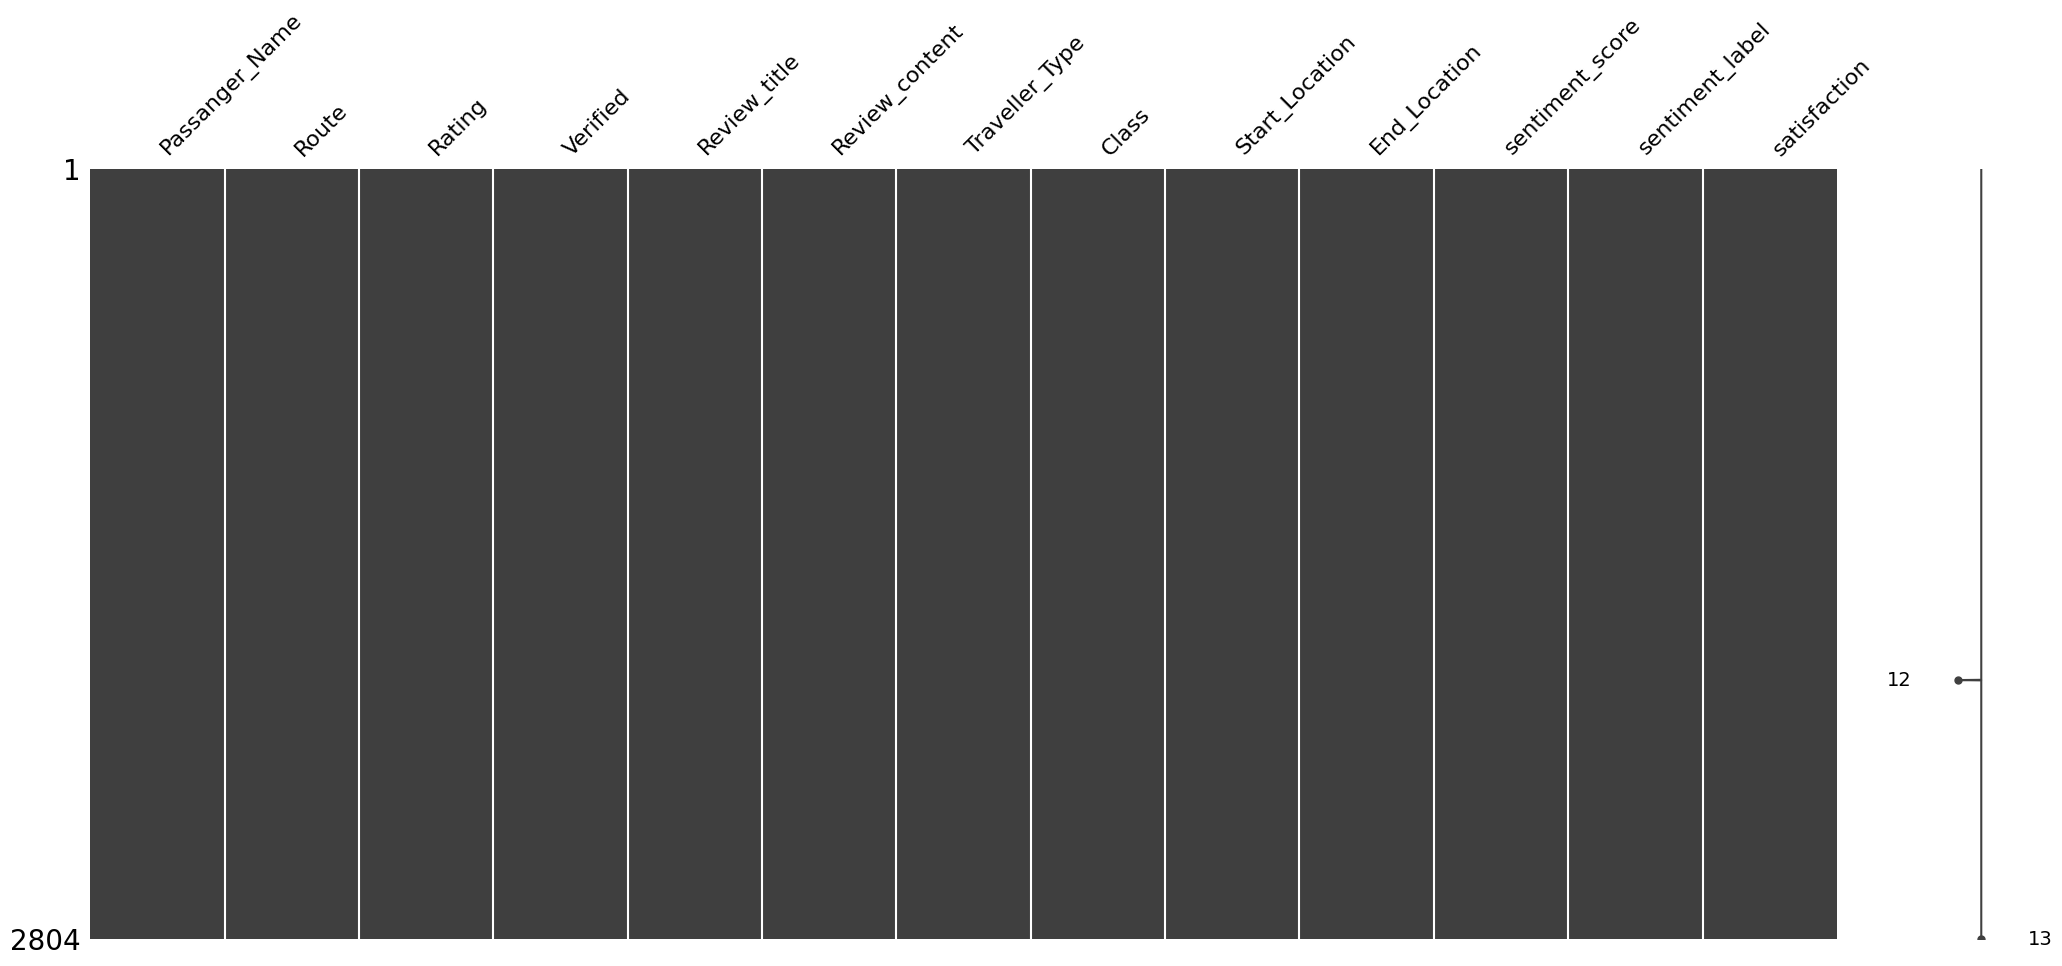

In [23]:
asr['satisfaction'] = asr['Rating'].apply(lambda x: 1 if x >= 5 else 0)
msno.matrix(asr)

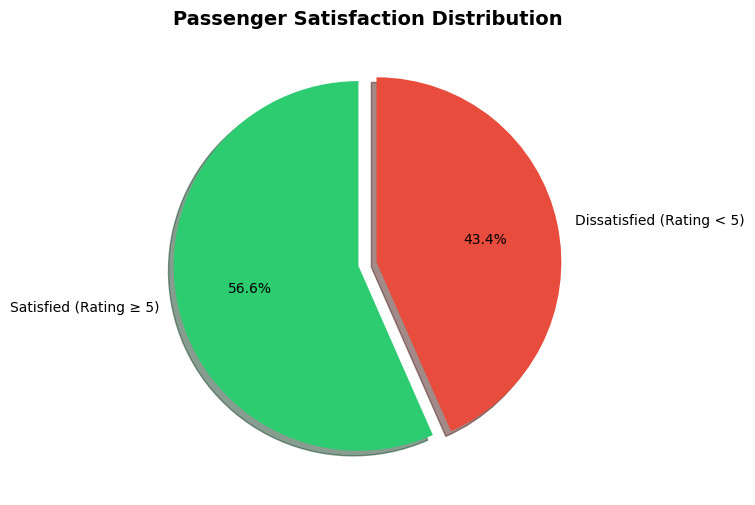

In [24]:
# ============================================================
# ✈️ Passenger Satisfaction Distribution (Pie Chart)
# ============================================================

# Count satisfied vs dissatisfied passengers
satisfaction_counts = asr['satisfaction'].value_counts()

# Define labels
labels = ['Satisfied (Rating ≥ 5)', 'Dissatisfied (Rating < 5)']

# Define colors
colors = ['#2ecc71', '#e74c3c']  # green for satisfied, red for dissatisfied

# Plot
plt.figure(figsize=(6,6))
plt.pie(
    satisfaction_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=(0.05, 0.05),
    shadow=True
)
plt.title('Passenger Satisfaction Distribution', fontsize=14, weight='bold')
plt.show()


Accuracy: 0.7718360071301248
Precision: 0.7562724014336918
Recall: 0.7785977859778598
F1 Score: 0.7672727272727273


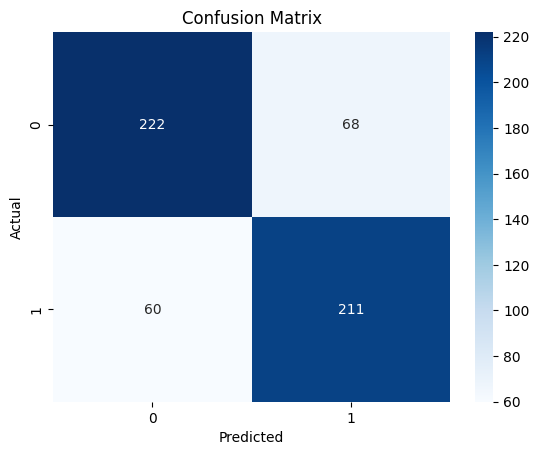

'\n1. Assumes a linear relationship between features and the log-odds of the target.\n2. Cannot automatically model complex or nonlinear interactions.\n3. Sensitive to outliers and multicollinearity between features.\n4. Performance may degrade with unscaled or highly imbalanced data.\n5. Limited predictive power compared to more flexible models (e.g., Neural Networks).\n'

In [25]:
features = ['Traveller_Type', 'Class', 'Verified', 'sentiment_score']
target = 'satisfaction'

X = asr[features]
y = asr[target]
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


cm= confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ===========================================
# ⚠️ Model Limitations: Logistic Regression
# ===========================================
"""
1. Assumes a linear relationship between features and the log-odds of the target.
2. Cannot automatically model complex or nonlinear interactions.
3. Sensitive to outliers and multicollinearity between features.
4. Performance may degrade with unscaled or highly imbalanced data.
5. Limited predictive power compared to more flexible models (e.g., Neural Networks).
"""

**FFNN**


2025-10-23 19:17:58.324981: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Training FFNN (5-layer)...
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7272 - loss: 0.5793 - precision: 0.7723 - recall: 0.4852 - val_accuracy: 0.7973 - val_loss: 0.4821 - val_precision: 0.7561 - val_recall: 0.7908
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8281 - loss: 0.4209 - precision: 0.7724 - recall: 0.8446 - val_accuracy: 0.8062 - val_loss: 0.4890 - val_precision: 0.7914 - val_recall: 0.7551
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8209 - loss: 0.4371 - precision: 0.7659 - recall: 0.8361 - val_accuracy: 0.8018 - val_loss: 0.4730 - val_precision: 0.7892 - val_recall: 0.7449
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8170 - loss: 0.4279 - precision: 0.7769 - recall: 0.8078 - val_accuracy: 0.8085 - val_loss: 0.4753 - val_precision: 0.7865 - val_recall: 0.7704
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8459 - loss: 0.3929 - precision: 0.8019 - recall: 0.8621 - val_accuracy: 0.

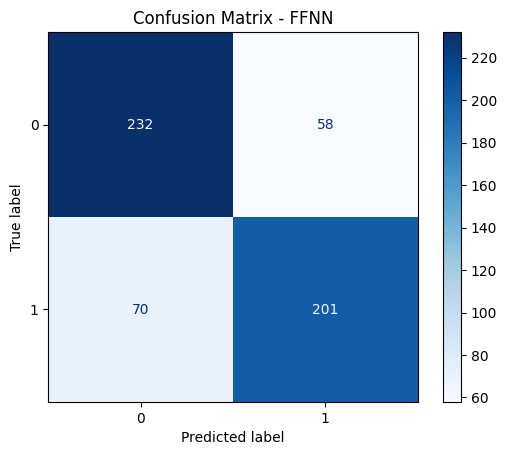

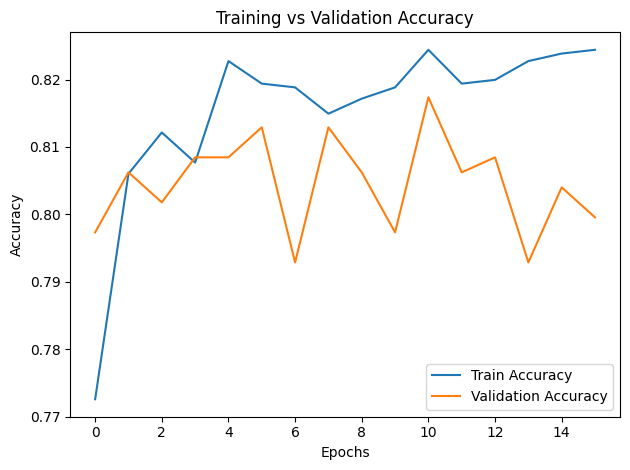

"\n1. Requires a large amount of data for stable generalization.\n2. Computationally expensive — training can be slow on large datasets.\n3. Acts as a 'black box' model — limited interpretability.\n4. Sensitive to hyperparameter tuning (learning rate, layers, etc.).\n5. High risk of overfitting without regularization (dropout, early stopping).\n6. Requires normalized input features for optimal performance.\n"

In [26]:
# ===========================================
#  FFNN Model for Passenger Satisfaction
# ===========================================


# -----------------------------
# 1️⃣ Select relevant features
# -----------------------------
features2 = ['Traveller_Type', 'Class', 'Verified', 'sentiment_score']
target2 = 'satisfaction'

# Encode categorical features
X2 = pd.get_dummies(asr[features2], drop_first=True)
y2 = asr[target2]

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=42
)

# Standardize numeric features
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

# -----------------------------
# 2️⃣ Define FFNN architecture
# -----------------------------
model2 = Sequential([
    Input(shape=(X_train2.shape[1],)),   # input layer

    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # output layer (binary classification)
])

# -----------------------------
# 3️⃣ Compile the model
# -----------------------------
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Early stopping (to prevent overfitting)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# -----------------------------
# 4️⃣ Train the model
# -----------------------------
print("\nTraining FFNN (5-layer)...")
history = model2.fit(
    X_train2, y_train2,
    epochs=50,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

# -----------------------------
# 5️⃣ Evaluate performance
# -----------------------------
y_pred_probs2 = model2.predict(X_test2)
y_pred2 = (y_pred_probs2 > 0.5).astype(int)

accuracy2 = accuracy_score(y_test2, y_pred2)
precision2 = precision_score(y_test2, y_pred2)
recall2 = recall_score(y_test2, y_pred2)
f12 = f1_score(y_test2, y_pred2)

print("\nModel Performance:")
print(f"Accuracy:  {accuracy2:.4f}")
print(f"Precision: {precision2:.4f}")
print(f"Recall:    {recall2:.4f}")
print(f"F1 Score:  {f12:.4f}")

# -----------------------------
# 6️⃣ Confusion Matrix
# -----------------------------
ConfusionMatrixDisplay(confusion_matrix(y_test2, y_pred2)).plot(cmap='Blues')
plt.title("Confusion Matrix - FFNN")
plt.show()

# -----------------------------
# 7️⃣ Optional: visualize learning curve
# -----------------------------
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# ===========================================
# ⚠️ Model Limitations: Feed-Forward Neural Network
# ===========================================

"""
1. Requires a large amount of data for stable generalization.
2. Computationally expensive — training can be slow on large datasets.
3. Acts as a 'black box' model — limited interpretability.
4. Sensitive to hyperparameter tuning (learning rate, layers, etc.).
5. High risk of overfitting without regularization (dropout, early stopping).
6. Requires normalized input features for optimal performance.
"""



📊 Model Comparison Summary:

                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression    0.7718     0.7563  0.7786    0.7673
1      Feed-Forward NN    0.7718     0.7761  0.7417    0.7585


<Figure size 1000x600 with 0 Axes>

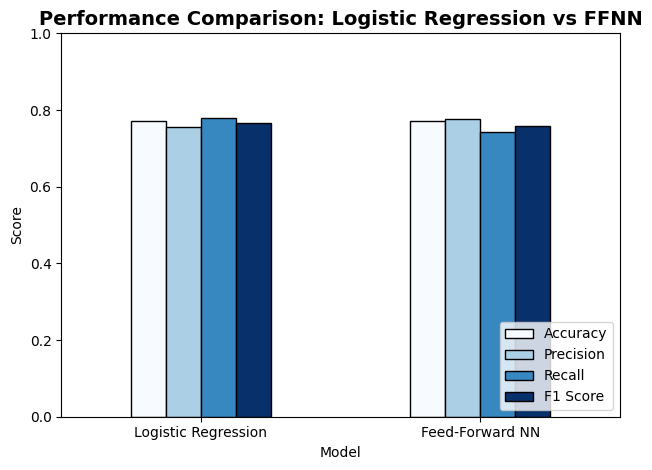

In [27]:
# ============================================================
# ⚖️ Model Comparison: Logistic Regression vs FFNN
# ============================================================

# --- 1️⃣ Store both model metrics ---
# Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred)
precision_lr = precision_score(y_test, y_pred)
recall_lr = recall_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)

# FFNN
accuracy_ffnn = accuracy2
precision_ffnn = precision2
recall_ffnn = recall2
f1_ffnn = f12

# --- 2️⃣ Create comparison DataFrame ---
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Feed-Forward NN'],
    'Accuracy': [accuracy_lr, accuracy_ffnn],
    'Precision': [precision_lr, precision_ffnn],
    'Recall': [recall_lr, recall_ffnn],
    'F1 Score': [f1_lr, f1_ffnn]
})

# Display summary table
print("\n📊 Model Comparison Summary:\n")
print(comparison.round(4))

# --- 3️⃣ Visualize comparison ---
plt.figure(figsize=(10,6))
comparison.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar',
    colormap='Blues',
    edgecolor='black'
)
plt.title("Performance Comparison: Logistic Regression vs FFNN", fontsize=14, weight='bold')
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


# Model Explainability 

**Logistic Regression**

  0%|          | 0/561 [00:00<?, ?it/s]

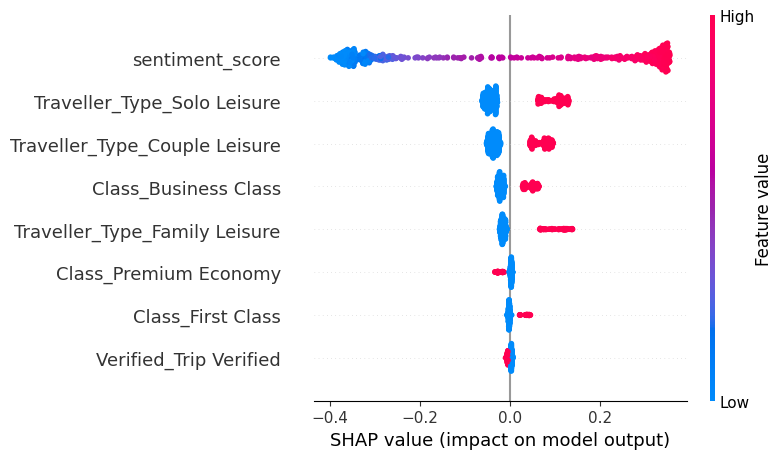

In [28]:


# -------------------------------
# GLOBAL SHAP
# -------------------------------
# Use KernelExplainer for logistic regression
explainer = shap.KernelExplainer(model.predict_proba, X_train)
shap_values = explainer.shap_values(X_test, nsamples=100)  # nsamples can be adjusted

# For binary classification, shap_values[1] corresponds to class 1
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns)


In [29]:
# -------------------------------
# LOCAL SHAP
# -------------------------------
i = 0  # explain row 0
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],  # class 1
    shap_values[1][i],
    X_test.iloc[i],
    feature_names=X.columns
)


In [30]:
# -------------------------------
# LIME
# -------------------------------
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,  # convert dataframe to numpy
    feature_names=X.columns,
    class_names=['Not Satisfied', 'Satisfied'],  # adjust to your target
    discretize_continuous=True
)

exp = explainer_lime.explain_instance(
    X_test.values[i],
    model.predict_proba,
    num_features=6
)

exp.show_in_notebook()


X does not have valid feature names, but LogisticRegression was fitted with feature names


**FFNN**

ExactExplainer explainer: 562it [00:22, 18.21it/s]                         


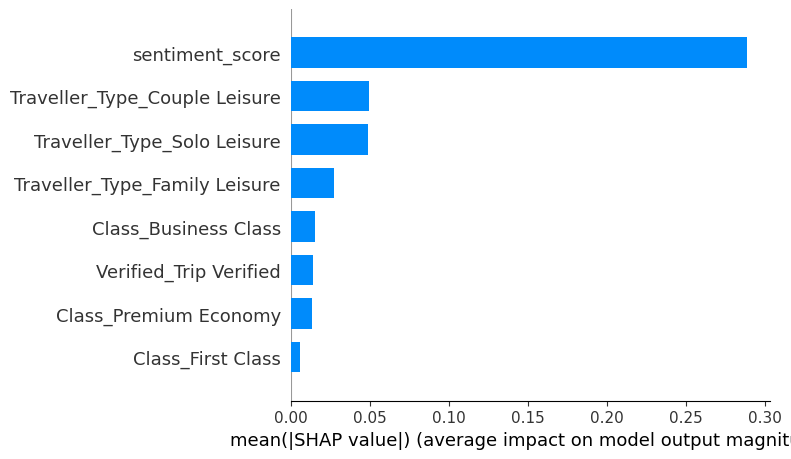

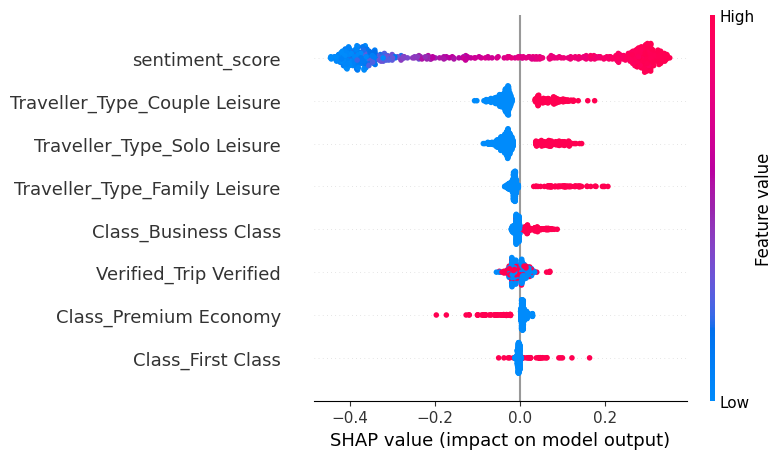

In [31]:
# -------------------------------
# 1️⃣ SHAP — Global and Local Explanations
# -------------------------------

# Wrap prediction function for SHAP (optional, Explainer can handle keras models)
def predict_fn(X):
    return model2.predict(X)

# Use a background sample for SHAP
background = shap.sample(pd.DataFrame(X_train2, columns=X2.columns),
                         100, random_state=42)

# Create explainer (SHAP auto-selects the best method for NN)
explainer = shap.Explainer(model2, background)

# Compute SHAP values on test set
shap_values = explainer(pd.DataFrame(X_test2, columns=X2.columns))

# -------------------------------
# Global summary (feature importance)
# -------------------------------
shap.summary_plot(shap_values.values, X_test2, feature_names=X2.columns, plot_type='bar')

# Classic SHAP beeswarm plot
shap.summary_plot(shap_values.values, X_test2, feature_names=X2.columns)


In [32]:
# -------------------------------
# Local explanation (first sample)
# -------------------------------
i = 0
shap.plots.force(shap_values[i])


In [33]:
# -------------------------------
# 2️⃣ LIME — Local Explanation
# -------------------------------

# Wrapper for LIME to provide both class probabilities
def predict_fn_lime(X):
    probs = model2.predict(X)
    return np.concatenate([1 - probs, probs], axis=1)  # class 0 & class 1

# Create LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train2,
    feature_names=X2.columns,
    class_names=['Not Satisfied', 'Satisfied'],
    discretize_continuous=True
)

# Explain a sample (e.g., first row)
j = 0
exp = explainer_lime.explain_instance(
    X_test2[j],
    predict_fn_lime,
    num_features=6
)

exp.show_in_notebook()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

def infer_passenger_satisfaction(traveller_type, flight_class, verified, review_text, model, scaler, feature_columns):
    """
    Predict passenger satisfaction using the trained model.
    """

    # Step 1️⃣ – Compute sentiment score from the review
    sentiment_score = sia.polarity_scores(str(review_text))['compound']

    # Step 2️⃣ – Build a one-row DataFrame
    input_data = pd.DataFrame([{
        'Traveller_Type': traveller_type,
        'Class': flight_class,
        'Verified': verified,
        'sentiment_score': sentiment_score
    }])

    # Step 3️⃣ – Apply same encoding as training
    input_encoded = pd.get_dummies(input_data, drop_first=True)
    input_encoded = input_encoded.reindex(columns=feature_columns, fill_value=0)

    # Step 4️⃣ – Scale numeric features
    input_scaled = scaler.transform(input_encoded)

    # ✅ Wrap back into a DataFrame to preserve column names for LogisticRegression
    input_scaled_df = pd.DataFrame(input_scaled, columns=feature_columns)

    # Step 5️⃣ – Make prediction
    prob = model.predict_proba(input_scaled_df)[0][1] if hasattr(model, "predict_proba") else model.predict(input_scaled_df).flatten()[0]

    # Step 6️⃣ – Convert probability to label
    label = 'Satisfied' if prob >= 0.5 else 'Dissatisfied'

    # Step 7️⃣ – Return results
    result = {
        'Traveller_Type': traveller_type,
        'Class': flight_class,
        'Verified': verified,
        'Sentiment_Score': round(sentiment_score, 3),
        'Predicted_Label': label,
        'Satisfaction_Probability': round(float(prob), 3)
    }

    print("\n--- Inference Result ---")
    for key, val in result.items():
        print(f"{key}: {val}")

    return result


In [35]:
# Use the same feature columns from training
feature_columns = X.columns

# Example new passenger input
infer_passenger_satisfaction(
    traveller_type='Business',
    flight_class='Economy Class',
    verified='True',
    review_text="The flight was smooth, and the staff were extremely helpful!",
    model=model,      # your trained model (Logistic Regression or FFNN)
    scaler=scaler,    # your StandardScaler used in training
    feature_columns=feature_columns
)



--- Inference Result ---
Traveller_Type: Business
Class: Economy Class
Verified: True
Sentiment_Score: 0.524
Predicted_Label: Dissatisfied
Satisfaction_Probability: 0.085


{'Traveller_Type': 'Business',
 'Class': 'Economy Class',
 'Verified': 'True',
 'Sentiment_Score': 0.524,
 'Predicted_Label': 'Dissatisfied',
 'Satisfaction_Probability': 0.085}